In [29]:
from __future__ import annotations
"""
TODO(Adriano) after getting some plots for the blobs post-SAE in GPT2, it's important to check whether these
SAEs are actually any good. Unfortunately, I have really bad FVUs, MSEs, etc... It's also unclear if a error
norm of 30 is normal. People seem not to be reporting this very well and it's deeply annoying.
"""
import os
from pathlib import Path
from typing import Dict, List
import torch
import torch.nn as nn
from datasets import load_dataset
from sae_lens import SAE, HookedSAETransformer
from torch.utils.data import DataLoader
import dotenv
from transformers import AutoTokenizer

from transformer_lens.utils import tokenize_and_concatenate

dotenv.load_dotenv()

class SAEExtractor:
    """
    Wraps a HookedSAETransformer and a bank of pre-trained SAEs to combine
    (1) loading the SAEs from the repository using SAELens, (2) Running them in
    a hooked transformer, getting activations, etc...

    This is meant ONLY for gpt2 and JBloom's SAEs.
    """

    def __init__(
        self,
        *,
        device: str | torch.device | None = None,
    ) -> None:
        self.model_name = "gpt2"
        self.sae_release = "gpt2-small-res-jb"
        self.device = "cuda" # NOTE: you should use CUDA_VISIBLE_DEVICES to select the GPU
        self.model = HookedSAETransformer.from_pretrained(self.model_name, device=self.device)
        self.tokenizer = self.model.tokenizer
        # self.saes: Dict[str, SAE] = {}
        self._load_saes()

    def _load_saes(self) -> None:
        # TODO(Adriano) make this more modular...
        self.block2sae = []
        self.cfg_dics = []
        self.sparsities = []
        # print(self.model.cfg.n_layers)
        for layer in range(self.model.cfg.n_layers):
            sae, cfg_dict, sparsity = SAE.from_pretrained(
                release = self.sae_release, # see other options in sae_lens/pretrained_saes.yaml
                sae_id = f"blocks.{layer}.hook_resid_pre", # won't always be a hook point
                device = self.device
            )
            self.block2sae.append(sae)
            self.cfg_dics.append(cfg_dict)
            self.sparsities.append(sparsity)

    def cache_activations(self, tokens: torch.Tensor, hooks: List[str] | None = None) -> Dict[str, torch.Tensor]:
        hooks = hooks or list(self.saes)
        _, cache = self.model.run_with_cache_with_saes(tokens, act_names=hooks)
        out: Dict[str, torch.Tensor] = {}
        for hook in hooks:
            out_key = f"{hook}.hook_sae_acts_post"
            out[out_key] = cache[out_key].cpu()
        return out

print("="*50 + " [Loading Dataset] " + "="*50) # DEBUG
# dataset = load_dataset("openwebtext", split="train", trust_remote_code=True)
dataset = load_dataset("stas/openwebtext-10k", split="train", trust_remote_code=True) # Smaller version
tokenizer = AutoTokenizer.from_pretrained("gpt2")
token_dataset = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=tokenizer,  # type: ignore
    streaming=True,
    # {
    #     'model_name': 'gpt2-small',
    #     'hook_point': 'blocks.0.hook_resid_pre',
    #     'hook_point_layer': 0,
    #     'hook_point_head_index': None,
    #     'dataset_path': 'Skylion007/openwebtext',
    #     'is_dataset_tokenized': False,
    #     'context_size': 128,
    #     'use_cached_activations': False,
    #     'cached_activations_path':
    #     'activations/Skylion007_openwebtext/gpt2-small/blocks.0.hook_resid_pre',
    #     'd_in': 768,
    #     'n_batches_in_buffer': 128,
    #     'total_training_tokens': 300000000,
    #     'store_batch_size': 32,
    #     'device': 'cuda', 
    #     'seed': 42, 'dtype': 'torch.float32', 'b_dec_init_method': 'geometric_median', 'expansion_factor': 32, 'from_pretrained_path': None, 'l1_coefficient': 8e-05, 'lr': 0.0004, 'lr_scheduler_name': None, 'lr_warm_up_steps': 5000, 'train_batch_size': 4096, 'use_ghost_grads': False, 'feature_sampling_window': 1000, 'feature_sampling_method': None, 'resample_batches': 1028, 'feature_reinit_scale': 0.2, 'dead_feature_window': 5000, 'dead_feature_estimation_method': 'no_fire', 'dead_feature_threshold': 1e-08, 'log_to_wandb': True, 'wandb_project': 'mats_sae_training_gpt2_small_resid_pre_5', 'wandb_entity': None, 'wandb_log_frequency': 100, 'n_checkpoints': 10, 'checkpoint_path': 'checkpoints/y1t51byy', 'd_sae': 24576, 'tokens_per_buffer': 67108864, 'run_name': '24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08', 'model_from_pretrained_kwargs': {'center_writing_weights': True}, 'neuronpedia_id': 'gpt2-small/0-res-jb', 'finetuning_scaling_factor': False, 'prepend_bos': True, 'dataset_trust_remote_code': True, 'apply_b_dec_to_input': True, 'sae_lens_training_version': None, 'activation_fn_str': 'relu', 'architecture': 'standard', 'normalize_activations': 'none'}

    max_length=128, #sae.cfg.context_size,
    add_bos_token=True, #sae.cfg.prepend_bos,
)
# print(token_dataset) # Sanity
# print(token_dataset[0]['tokens']) # Sanity

print("="*50 + " [Loading Model] " + "="*50) # DEBUG
extractor = SAEExtractor()
for d in extractor.cfg_dics:
    print(d["context_size"]) # NOTE: you should picke the smallest of these...

================================================== [Loading Dataset] ==================================================
================================================== [Loading Model] ==================================================
Loaded pretrained model gpt2 into HookedTransformer


/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


128
128
128
128
128
128
128
128
128
128
128
128


In [30]:
import tqdm
import torch
import gc
import matplotlib.pyplot as plt
gc.collect()
torch.cuda.empty_cache()

token_dataset_short = token_dataset[:3000]['tokens']
dataset_length = token_dataset_short.shape[0]
sequence_length = token_dataset_short.shape[1]
sae_ins = torch.zeros((len(extractor.block2sae), dataset_length, sequence_length, extractor.model.cfg.d_model), device="cpu")
sae_outs = torch.zeros((len(extractor.block2sae), dataset_length, sequence_length, extractor.model.cfg.d_model), device="cpu")
print(sae_ins.shape)
print(sae_outs.shape)
for i in range(len(extractor.block2sae)):
    extractor.block2sae[i].eval()

batch_size = 30
while True:
    try:
        pbar = tqdm.trange(0, len(token_dataset_short), batch_size, desc=f"Batch Size = {batch_size}")
        with torch.no_grad():
            for i in pbar:
                j = min(i + batch_size, len(token_dataset_short))
                # activation store can give us tokens.
                batch_tokens = token_dataset_short[i:j]
                _, cache = extractor.model.run_with_cache(batch_tokens, prepend_bos=True)

                # print(cache.keys())
                # Use the SAE
                # print(len(extractor.block2sae))
                # print(f"hook_name={extractor.block2sae[8].cfg.hook_name}") # Nope
                sae_in = torch.stack([cache[extractor.block2sae[i].cfg.hook_name].detach() for i in range(len(extractor.block2sae))])
                del cache
                gc.collect()
                torch.cuda.empty_cache()
                # feature_acts = [extractor.block2sae[i].encode(sae_in[i])
                sae_out = torch.stack([extractor.block2sae[i](sae_in[i]).detach().cpu() for i in range(len(extractor.block2sae))])

                assert sae_in.shape == sae_out.shape
                assert sae_in.shape[0] == len(extractor.block2sae)
                assert sae_in.shape[1] == j - i
                assert sae_in.shape[2] == sequence_length
                assert sae_in.shape[3] == extractor.model.cfg.d_model, f"sae_in.shape={sae_in.shape}, need [2] = {extractor.model.cfg.d_model}" # fmt: skip
                assert sae_in.ndim == 4
                sae_ins[:, i:j, :] = sae_in.cpu()
                sae_outs[:, i:j, :] = sae_out.cpu()
        break # OK
    except torch.OutOfMemoryError as e:
        print(type(e), e)
        if batch_size == 1:
            raise e
        batch_size = min(1, batch_size // 2)

torch.Size([12, 3000, 128, 768])
torch.Size([12, 3000, 128, 768])


Batch Size = 30: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


In [ ]:
#         # ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
#         # l0 = (feature_acts[:, 1:] > 0).float().sum(-1).detach()
#         for i in range(len(extractor.block2sae)):
#             err_norm = (sae_out[i] - sae_in[i]).norm(dim=-1).detach()
#             fvu = ((sae_out[i] - sae_in[i]).pow(2).sum(dim=-1) / sae_in[i].pow(2).sum(dim=-1))
#             mse = (sae_out[i] - sae_in[i]).pow(2).mean(dim=-1).detach() # "variance explained"
#             # TODO(Adriano) error norm seems REALLY BAD
#             print(f"average error norm: {err_norm.mean().item()} +/- {err_norm.std().item()}; min={err_norm.min().item()}, max={err_norm.max().item()}")
#             print(f"average mse: {mse.mean().item()} +/- {mse.std().item()}; min={mse.min().item()}, max={mse.max().item()}")
#             print(f"average fvu: {fvu.mean().item()} +/- {fvu.std().item()}; min={fvu.min().item()}, max={fvu.max().item()}")
#             plt.hist(err_norm.flatten().cpu().log10().numpy(), bins=100) # around 100-1000 error => maybe around 0.7-7 error? => around 1.2 for this shit
#             plt.show()
#             gc.collect()
#             torch.cuda.empty_cache()

# for i in range(len(extractor.block2sae)):
#     print(extractor.cfg_dics[i])
#     assert extractor.block2sae[i].cfg.hook_name == extractor.cfg_dics[i]["hook_name"]
    

Flattening
Computing explained variances
torch.Size([3840])
torch.Size([3840])
torch.Size([3840])
torch.Size([3840])
torch.Size([3840])
torch.Size([3840])
torch.Size([3840])
torch.Size([3840])
torch.Size([3840])
torch.Size([3840])
torch.Size([3840])
torch.Size([3840])
torch.Size([12])
torch.Size([12])
torch.Size([12])
torch.Size([12])
Explained variance: 1.0000 +/- 0.0001
Min=0.9989 <= Median=1.0000 <= Max=1.0000


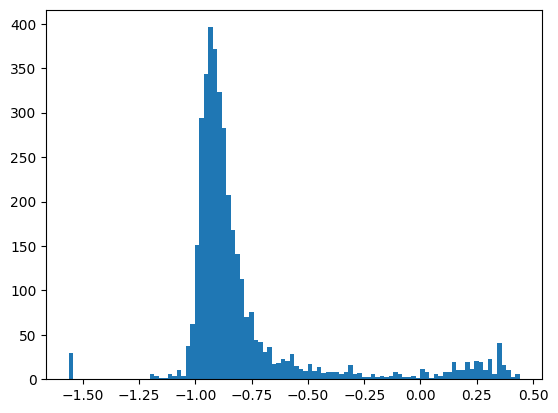

Explained variance: 0.9790 +/- 0.0274
Min=0.6876 <= Median=0.9883 <= Max=1.0000


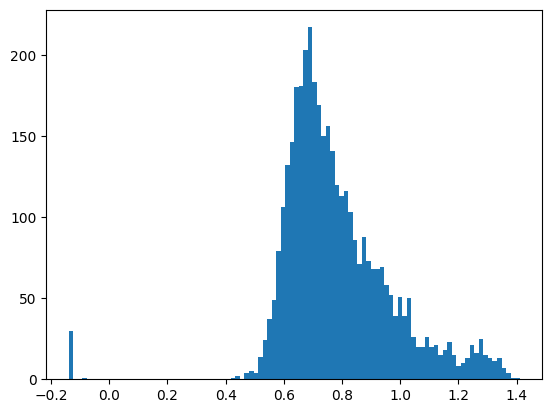

Explained variance: 0.9619 +/- 0.0416
Min=0.5710 <= Median=0.9773 <= Max=1.0000


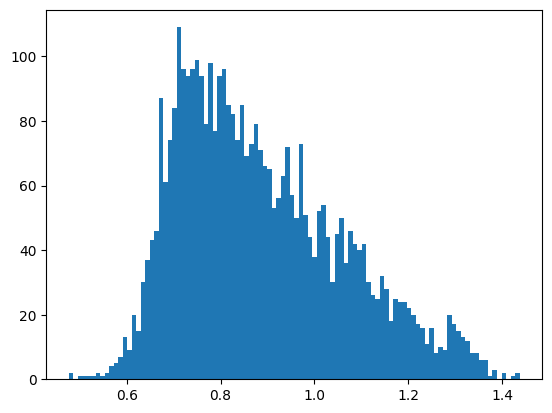

Explained variance: 0.9140 +/- 0.0756
Min=0.1847 <= Median=0.9401 <= Max=0.9998


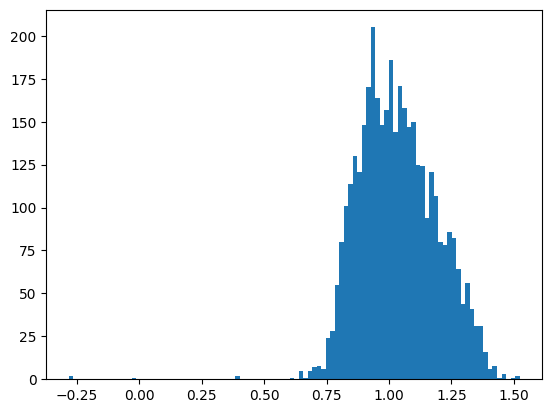

Explained variance: 0.8214 +/- 0.1432
Min=-0.3452 <= Median=0.8685 <= Max=1.0000


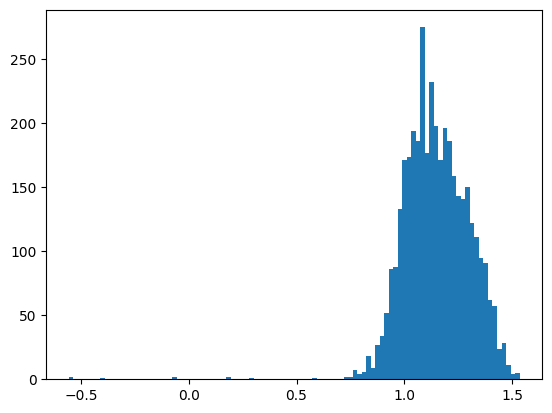

Explained variance: 0.6914 +/- 0.2286
Min=-0.7054 <= Median=0.7649 <= Max=1.0000


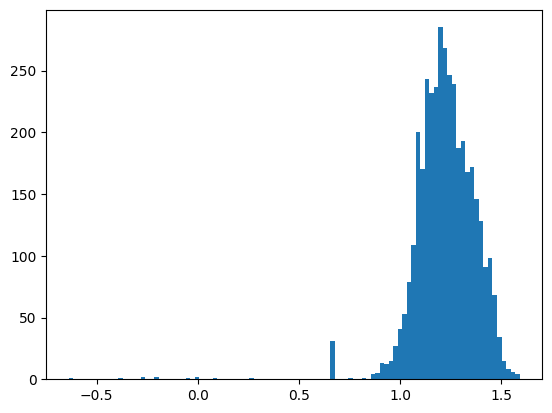

Explained variance: 0.4642 +/- 0.3569
Min=-1.7566 <= Median=0.5716 <= Max=0.9999


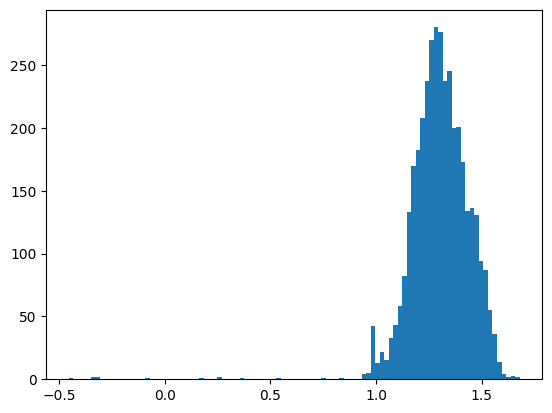

Explained variance: 0.1931 +/- 0.4054
Min=-1.9195 <= Median=0.2972 <= Max=0.9999


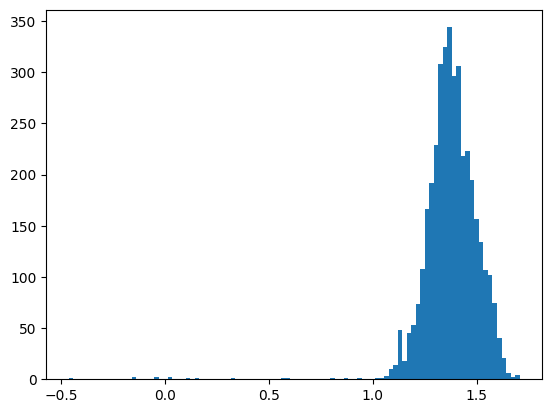

Explained variance: 0.2215 +/- 0.2993
Min=-1.5290 <= Median=0.2639 <= Max=0.9999


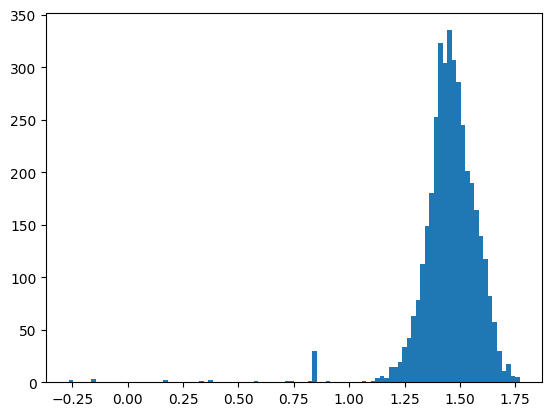

Explained variance: 0.4713 +/- 0.2266
Min=-0.7501 <= Median=0.5066 <= Max=0.9999


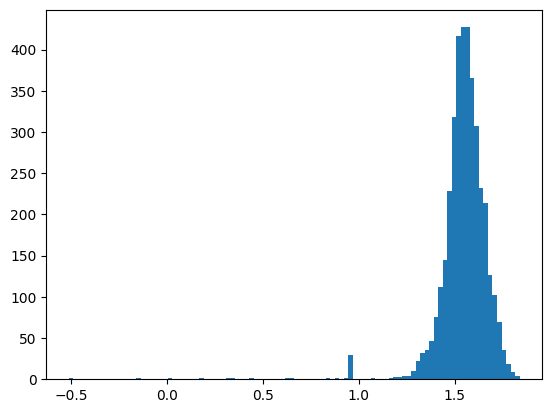

Explained variance: 0.6374 +/- 0.1719
Min=-0.1775 <= Median=0.6735 <= Max=0.9961


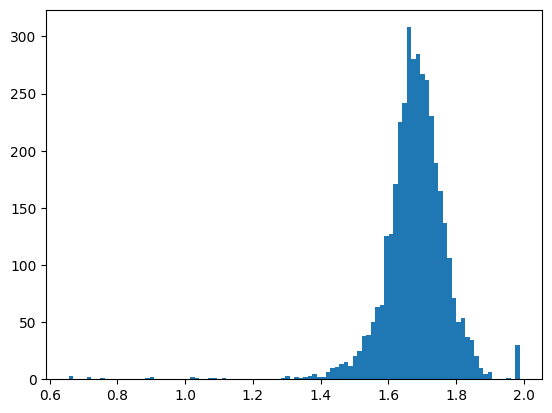

Explained variance: 0.8380 +/- 0.0816
Min=0.3286 <= Median=0.8519 <= Max=1.0000


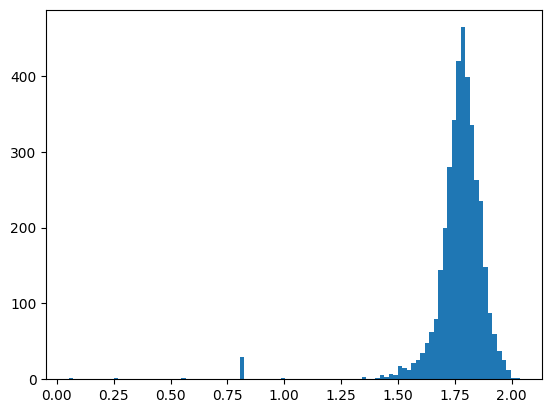

In [31]:
import einops
print("Flattening")

flatten = "layer batch seq dim -> layer (batch seq) dim"
sae_in_flat = einops.rearrange(sae_in, flatten).cpu()
sae_out_flat = einops.rearrange(sae_out, flatten).cpu()

print("Computing explained variances")
# https://github.com/jbloomAus/SAELens/blob/be0e55f69d360a0100027de1cf3f1a1606cf5552/sae_lens/evals.py#L512
sq_errs = (sae_in_flat - sae_out_flat).pow(2).sum(dim=-1) # norms of errors
var = (sae_in_flat - sae_in_flat.mean(dim=0)).pow(2).sum(dim=-1) # variance of 1st dim then sum those
explained_variances = 1 - sq_errs / var
print("\n".join(map(lambda x: str(x.shape), explained_variances)))
# Across batch and sequence unique per layer
print("="*100)
mean_evs = explained_variances.mean(dim=-1)
std_evs = explained_variances.std(dim=-1)
max_evs = explained_variances.max(dim=-1).values
min_evs = explained_variances.min(dim=-1).values
median_evs = explained_variances.median(dim=-1).values
print(mean_evs.shape)
print(std_evs.shape)
print(max_evs.shape)
print(min_evs.shape)
print("="*100)
for mean, std, _max, _min, median, err_norm in zip(
    mean_evs, std_evs, max_evs, min_evs, median_evs, sq_errs
):
    print(f"Explained variance: {mean.item():.4f} +/- {std.item():.4f}")
    print(f"Min={_min.item():.4f} <= Median={median.item():.4f} <= Max={_max.item():.4f}")
    print("="*50)

    # ehh...
    plt.hist(err_norm.sqrt().flatten().cpu().log10().numpy(), bins=100)
    plt.show()
    gc.collect()
    torch.cuda.empty_cache()

# # Plot the explained variances for each layer
# plt.figure(figsize=(10, 6))
# plt.errorbar(
#     range(len(mean_evs)), 
#     mean_evs, 
#     yerr=std_evs, 
#     fmt='o-', 
#     capsize=5, 
#     label='Mean Explained Variance with Std Dev'
# )
# plt.fill_between(
#     range(len(mean_evs)),
#     min_evs,
#     max_evs,
#     alpha=0.2,
#     label='Min-Max Range'
# )
# plt.xlabel('Layer')
# plt.ylabel('Explained Variance')
# plt.title('Explained Variance by Layer')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Print summary statistics
# print(f"\nOverall mean explained variance: {sum(mean_evs)/len(mean_evs):.4f}")
# print(f"Best layer: {torch.argmax(torch.Tensor(mean_evs)).item()} with {max(mean_evs):.4f}")
# print(f"Worst layer: {torch.argmin(torch.Tensor(mean_evs)).item()} with {min(mean_evs):.4f}")

In [ ]:
"""
Now here is what we want to do: (1) plot the PCAs of the sae_ins and THEN plot the PCAs of the sae_outs.
We can calculate PCAs more quickly using matmul to get cov matrix and then SVD.
"""
# Get the covariance matrices
# 1. GPU for speed
batchseq = sae_in_flat.shape[1]
sae_in_flat, sae_out_flat = sae_in_flat.cuda(), sae_out_flat.cuda()
# 2. Center
sae_in_flat_mean = sae_in_flat.mean(dim=1, keepdim=True)
sae_in_flat = sae_in_flat - sae_in_flat_mean
sae_out_flat_mean = sae_out_flat.mean(dim=1, keepdim=True)
sae_out_flat = sae_out_flat - sae_out_flat_mean
# Get covariance matrices
cov_sae_ins = einops.einsum(sae_in_flat, sae_in_flat, "layer batchseq dim1, layer batchseq dim2 -> layer dim1 dim2").cpu()
cov_sae_outs = einops.einsum(sae_out_flat, sae_out_flat, "layer batchseq dim1, layer batchseq dim2 -> layer dim1 dim2").cpu()
cov_sae_ins = cov_sae_ins / (batchseq - 1)
cov_sae_outs = cov_sae_outs / (batchseq - 1)

# Get the SVD decompositions to get the principal components
eigendecomposition_sae_ins = torch.linalg.eigh(cov_sae_ins)
eigendecomposition_sae_outs = torch.linalg.eigh(cov_sae_outs)

# Get these
eigenvectors_sae_ins = eigendecomposition_sae_ins.eigenvectors
eigenvectors_sae_outs = eigendecomposition_sae_outs.eigenvectors
eigenvalues_sae_ins = eigendecomposition_sae_ins.eigenvalues
eigenvalues_sae_outs = eigendecomposition_sae_outs.eigenvalues
print("eigenvectors_sae_ins.shape", eigenvectors_sae_ins.shape)
print("eigenvectors_sae_outs.shape", eigenvectors_sae_outs.shape)
print("eigenvalues_sae_ins.shape", eigenvalues_sae_ins.shape)
print("eigenvalues_sae_outs.shape", eigenvalues_sae_outs.shape)










# Define a function to calculate cosine similarity between two sets of vectors
def compute_cosine_similarity(vectors1, vectors2):
    """
    By claude.
    """
    # Normalize vectors
    vectors1_norm = vectors1 / torch.norm(vectors1, dim=0, keepdim=True)
    vectors2_norm = vectors2 / torch.norm(vectors2, dim=0, keepdim=True)
    
    # Compute cosine similarity matrix
    return torch.matmul(vectors1_norm.T, vectors2_norm)

# Define a function to plot a heatmap of a matrix
def plot_heatmap(matrix, title, xlabel, ylabel, figsize=(14, 12), cmap='viridis', vmin=-1, vmax=1, save_to_file=None):
    """
    By Claude.
    """
    plt.figure(figsize=figsize)
    
    # Convert to numpy if it's a tensor
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.cpu().numpy()
    
    # Use imshow instead of seaborn's heatmap for better performance with large matrices
    plt.imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
    plt.colorbar(label='Cosine Similarity')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    # Force the plot to be drawn
    plt.draw()
    
    # # Show the plot
    # plt.show()
    
    # Save if requested
    if save_to_file:
        plt.savefig(save_to_file)
    else:
        plt.show()
    
    # Close the plot after everything is done
    plt.close()

# Function to analyze eigenvector similarity for a specific layer
def analyze_eigenvector_similarity(layer_idx, eigenvectors_sae_ins, eigenvectors_sae_outs, save_to_file=None):
    """
    By Claude.
    """
    # Get eigenvectors for the selected layer
    eigenvecs_ins = eigenvectors_sae_ins[layer_idx]
    eigenvecs_outs = eigenvectors_sae_outs[layer_idx]
    
    # Compute cosine similarity
    cosine_sim = compute_cosine_similarity(eigenvecs_ins, eigenvecs_outs)
    
    # Plot the cosine similarity matrix
    plot_heatmap(
        cosine_sim, 
        f'Cosine Similarity Between SAE Ins and Outs Eigenvectors (Layer {layer_idx})',
        'SAE Outs Eigenvectors',
        'SAE Ins Eigenvectors',
        save_to_file=save_to_file
    )
    
    return cosine_sim

# Analyze a specific layer (e.g., layer 0)
# cosine_sim_layer0 = analyze_eigenvector_similarity(0, eigenvectors_sae_ins, eigenvectors_sae_outs)

# # Print some statistics about the cosine similarity
# print(f"Max cosine similarity: {cosine_sim_layer0.max().item():.4f}")
# print(f"Min cosine similarity: {cosine_sim_layer0.min().item():.4f}")
# print(f"Mean absolute cosine similarity: {cosine_sim_layer0.abs().mean().item():.4f}")

plots_output_folder = Path("plots_cosine_sim_pca_post_sae")
import shutil
if plots_output_folder.exists() and len(list(plots_output_folder.glob("*"))) == 0:
    shutil.rmtree(plots_output_folder)
plots_output_folder.mkdir(parents=True, exist_ok=False)

# You can also analyze multiple layers
print("\nAnalyzing multiple layers...")
for layer in range(len(extractor.block2sae)):
    print(f"\nLayer {layer}:")
    cosine_sim = analyze_eigenvector_similarity(layer, eigenvectors_sae_ins, eigenvectors_sae_outs, save_to_file=plots_output_folder / f"layer_{layer}.png")
    
    # Find the top aligned eigenvectors
    max_values, max_indices = torch.max(cosine_sim.abs(), dim=1)
    top_k = 5
    top_indices = torch.argsort(max_values, descending=True)[:top_k]
    
    print(f"Top {top_k} aligned eigenvector pairs (SAE in → SAE out):")
    for i, idx in enumerate(top_indices):
        out_idx = max_indices[idx]
        sim_value = cosine_sim[idx, out_idx].item()
        print(f"  {i+1}. In eigenvector {idx} aligns with out eigenvector {out_idx} (sim={sim_value:.4f})")



eigenvectors_sae_ins.shape torch.Size([12, 768, 768])
eigenvectors_sae_outs.shape torch.Size([12, 768, 768])
eigenvalues_sae_ins.shape torch.Size([12, 768])
eigenvalues_sae_outs.shape torch.Size([12, 768])

Analyzing multiple layers...

Layer 0:
Top 5 aligned eigenvector pairs (SAE in → SAE out):
  1. In eigenvector 767 aligns with out eigenvector 767 (sim=0.9999)
  2. In eigenvector 764 aligns with out eigenvector 764 (sim=0.9996)
  3. In eigenvector 766 aligns with out eigenvector 766 (sim=0.9995)
  4. In eigenvector 763 aligns with out eigenvector 763 (sim=0.9995)
  5. In eigenvector 762 aligns with out eigenvector 762 (sim=0.9992)

Layer 1:
Top 5 aligned eigenvector pairs (SAE in → SAE out):
  1. In eigenvector 767 aligns with out eigenvector 767 (sim=-0.9985)
  2. In eigenvector 766 aligns with out eigenvector 766 (sim=-0.9981)
  3. In eigenvector 765 aligns with out eigenvector 765 (sim=-0.9979)
  4. In eigenvector 764 aligns with out eigenvector 764 (sim=-0.9977)
  5. In eigenve

In [64]:
# print(eigenvalues_sae_ins) # NOTE this is sorted ascending
print(sae_in_flat.shape)
sae_in_flat_mean = sae_in_flat.mean(dim=1, keepdim=True)
sae_out_flat_mean = sae_out_flat.mean(dim=1, keepdim=True)
print(sae_in_flat_mean.shape)
print(sae_out_flat_mean.shape)

torch.Size([12, 3840, 768])
torch.Size([12, 1, 768])
torch.Size([12, 1, 768])


  0%|          | 0/12 [00:00<?, ?it/s]

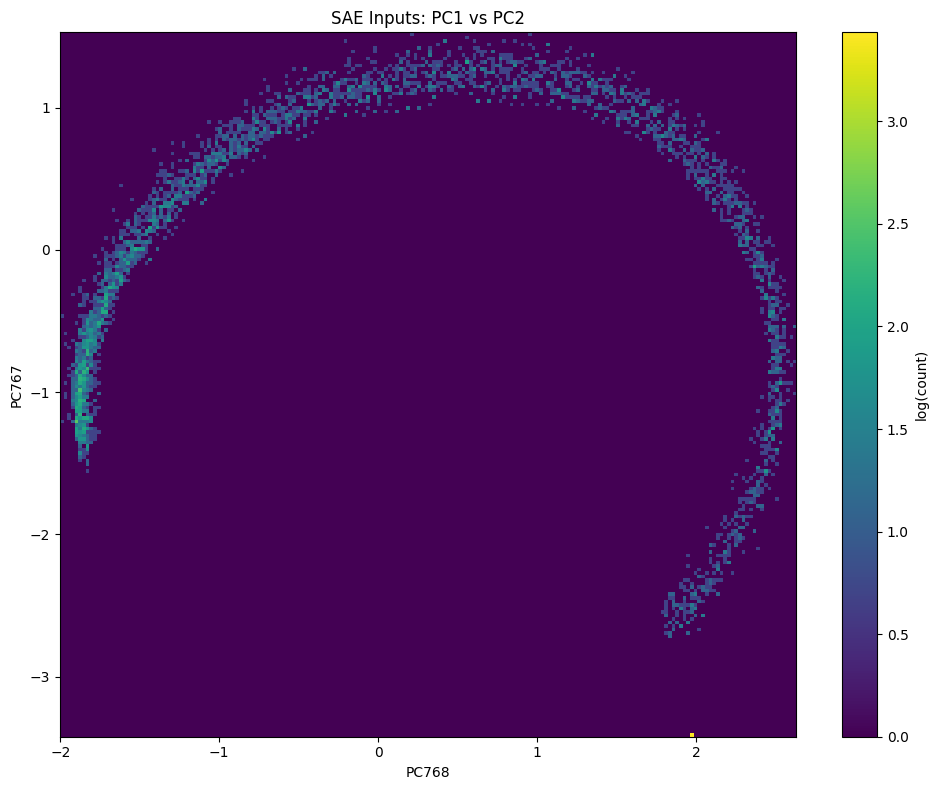

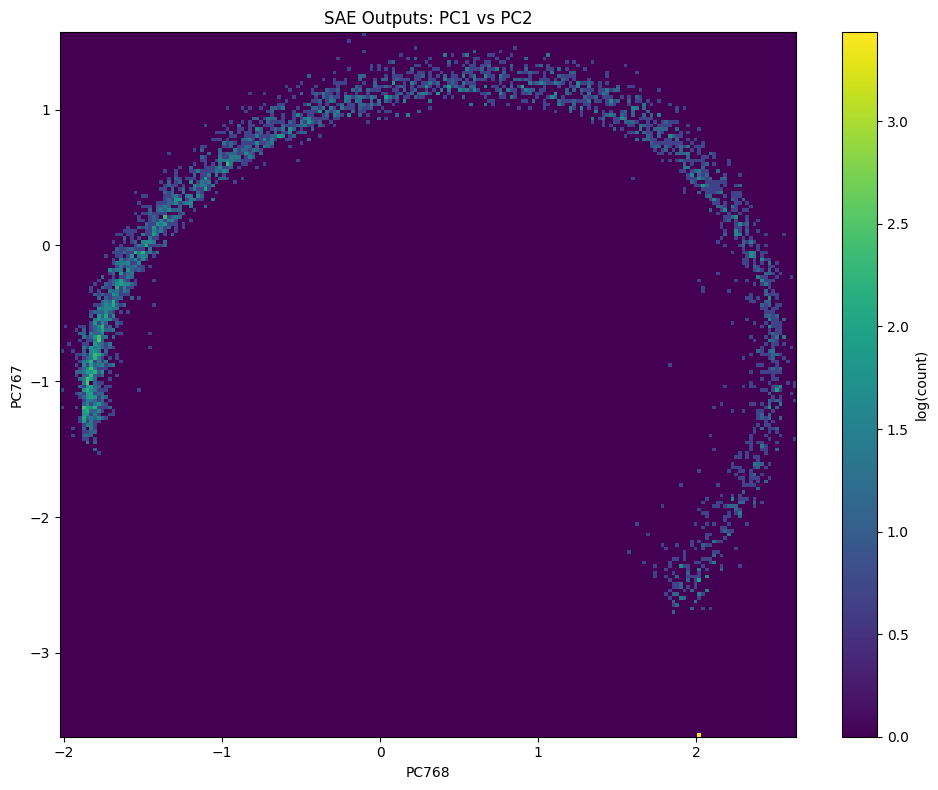

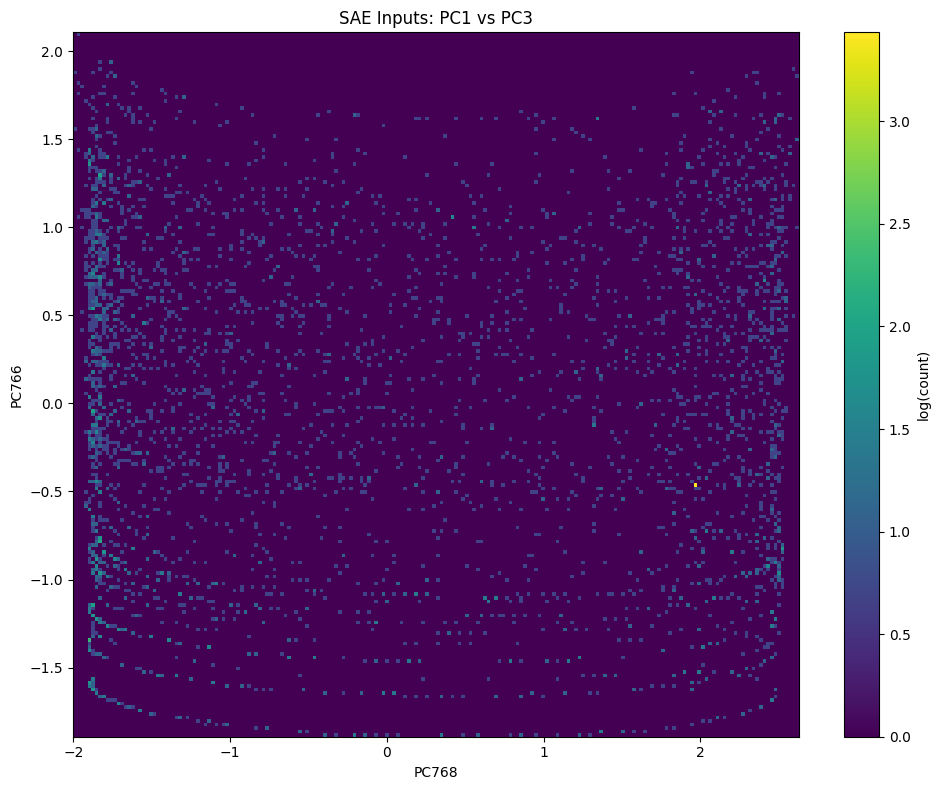

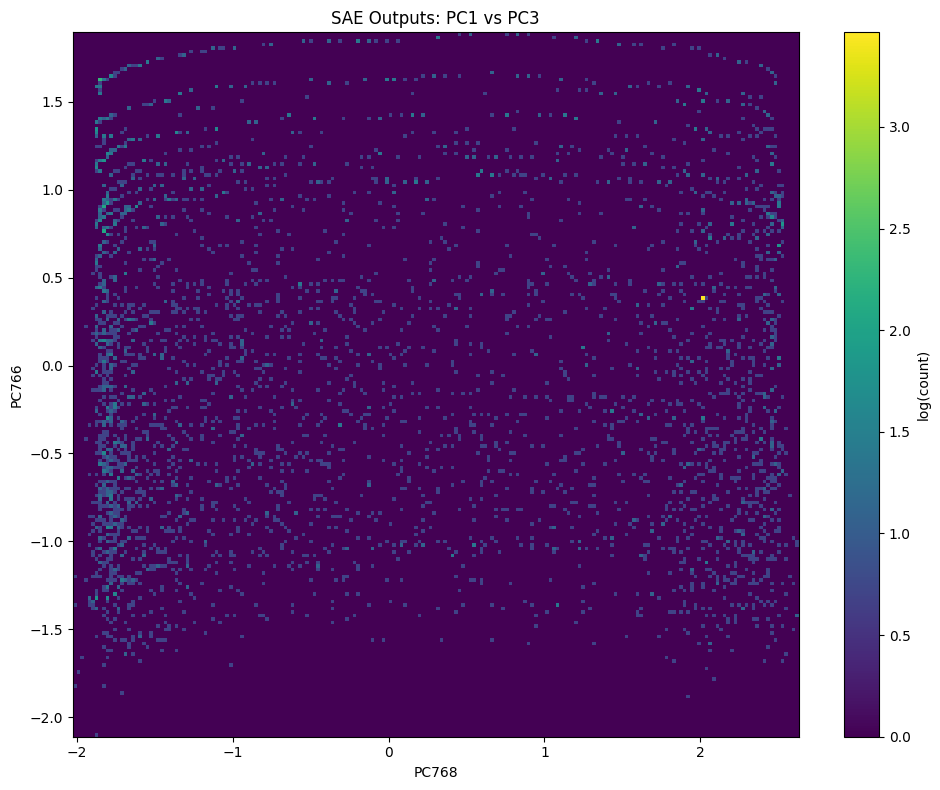

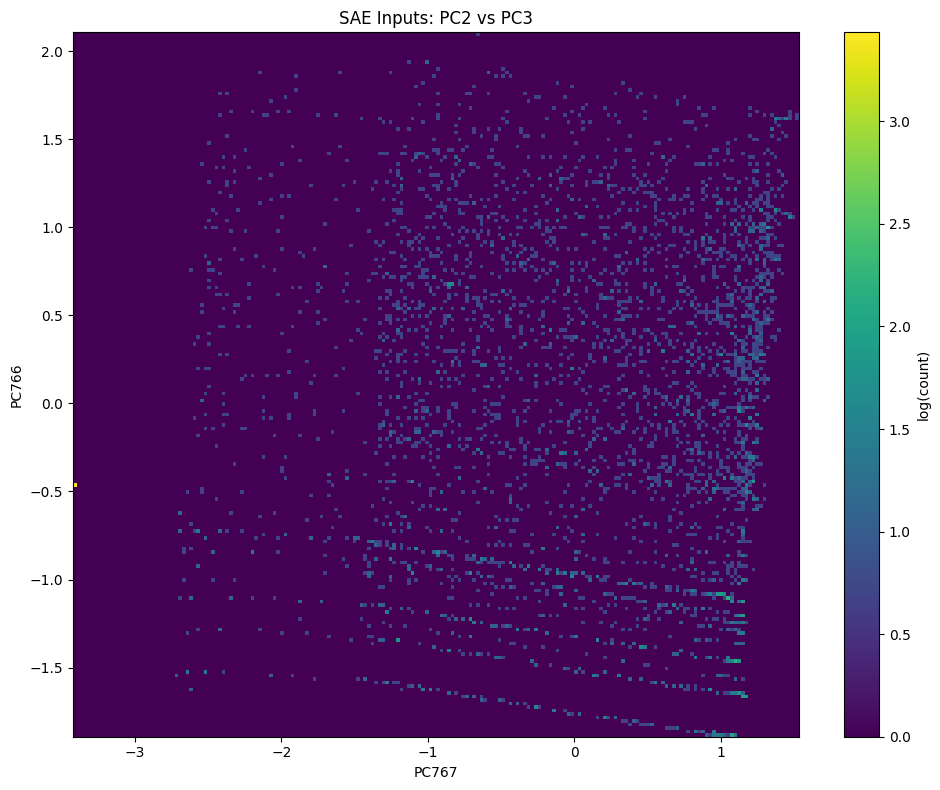

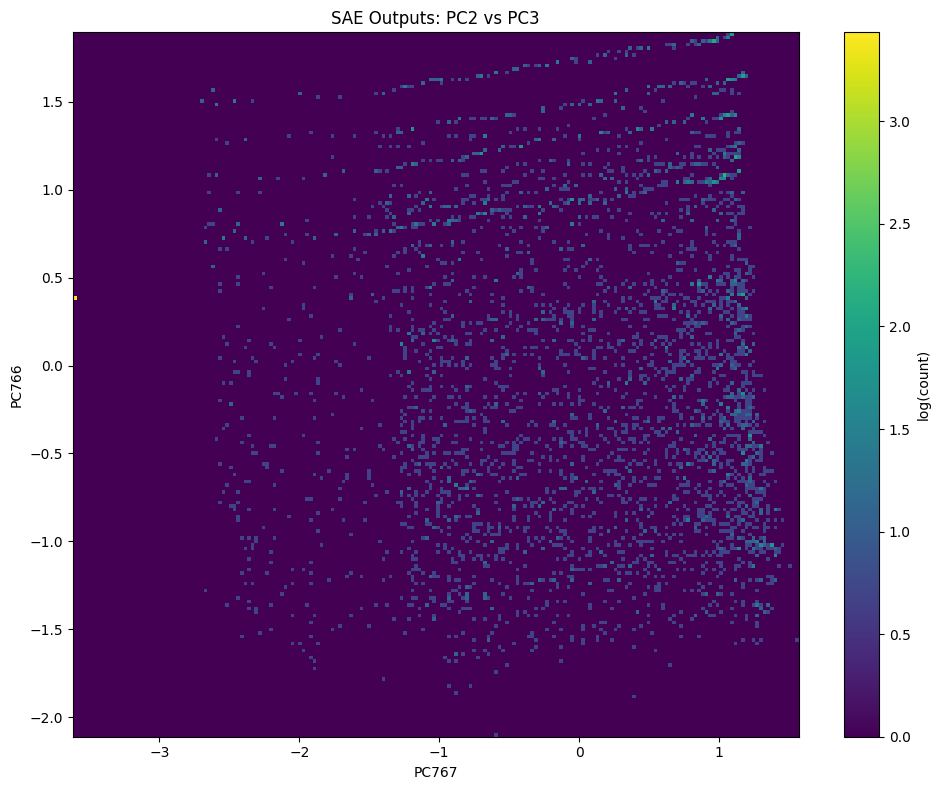

  8%|▊         | 1/12 [00:04<00:47,  4.31s/it]

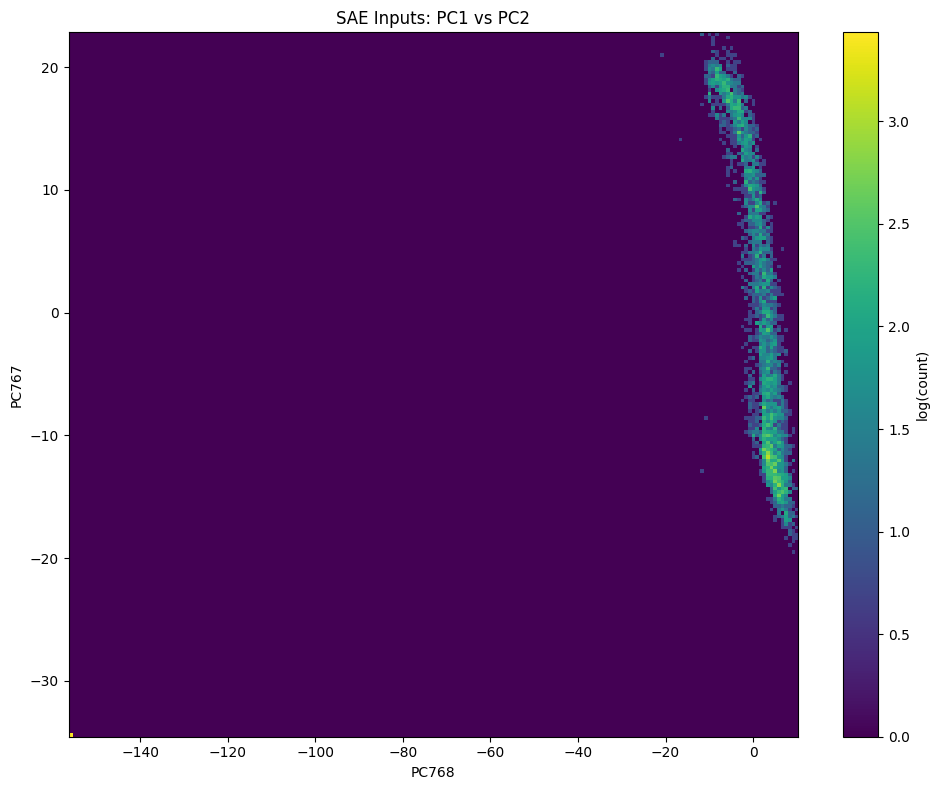

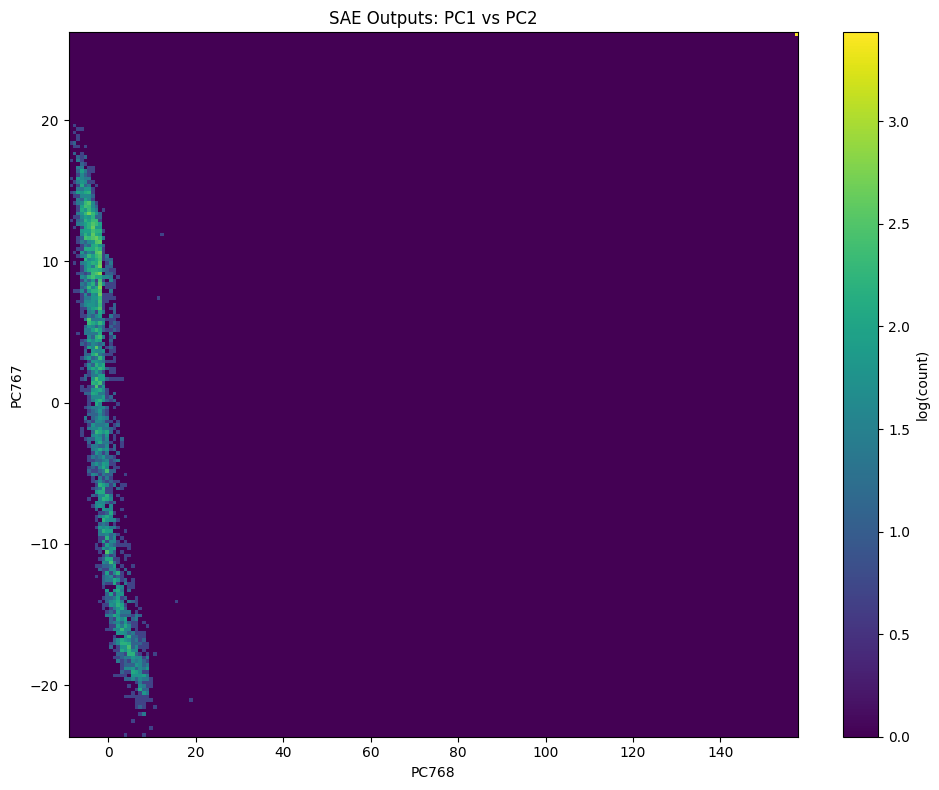

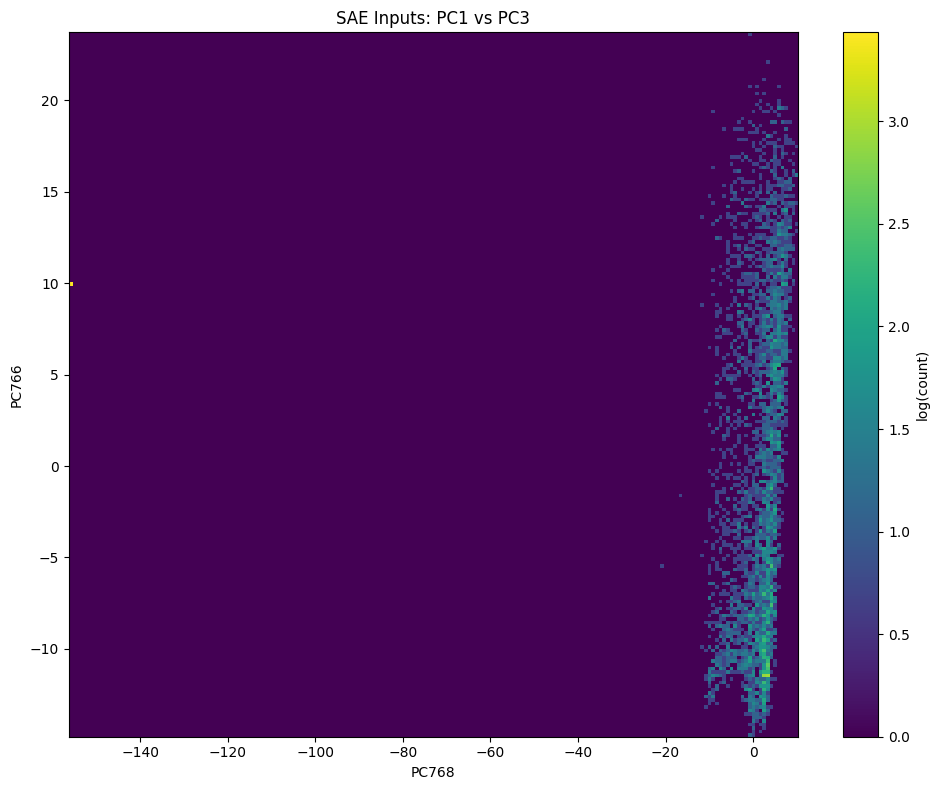

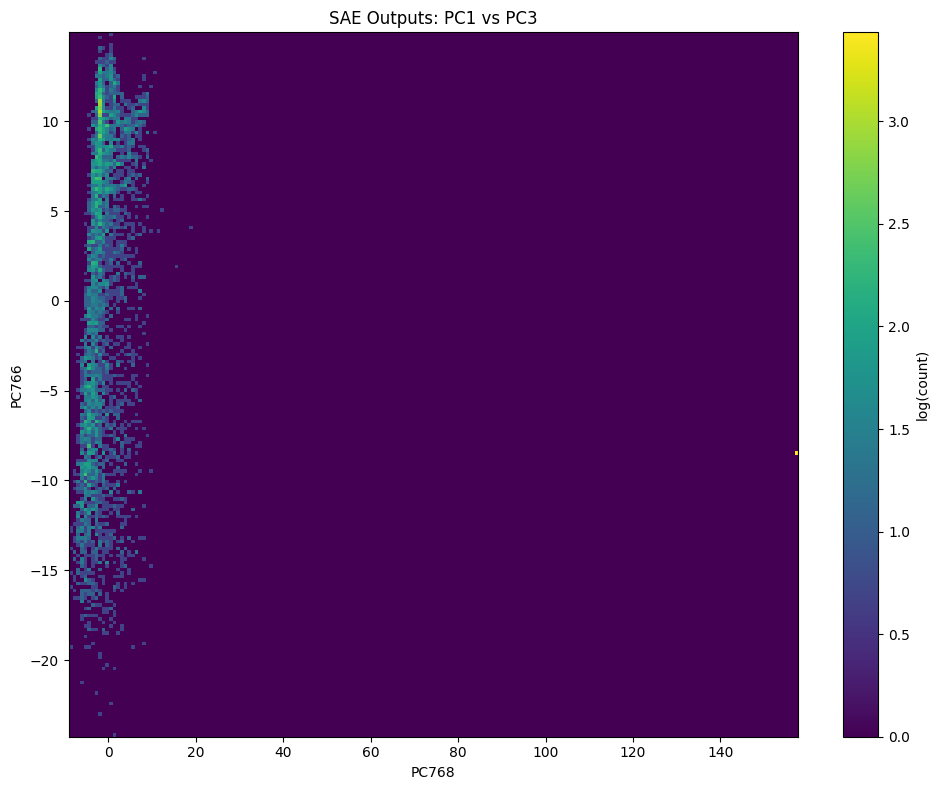

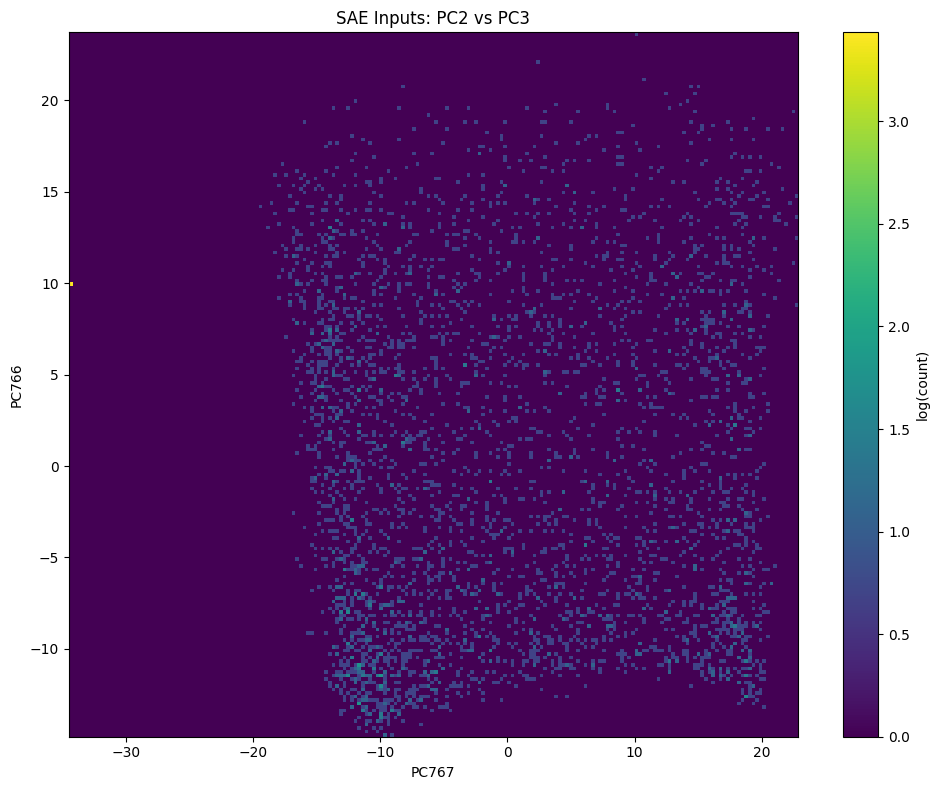

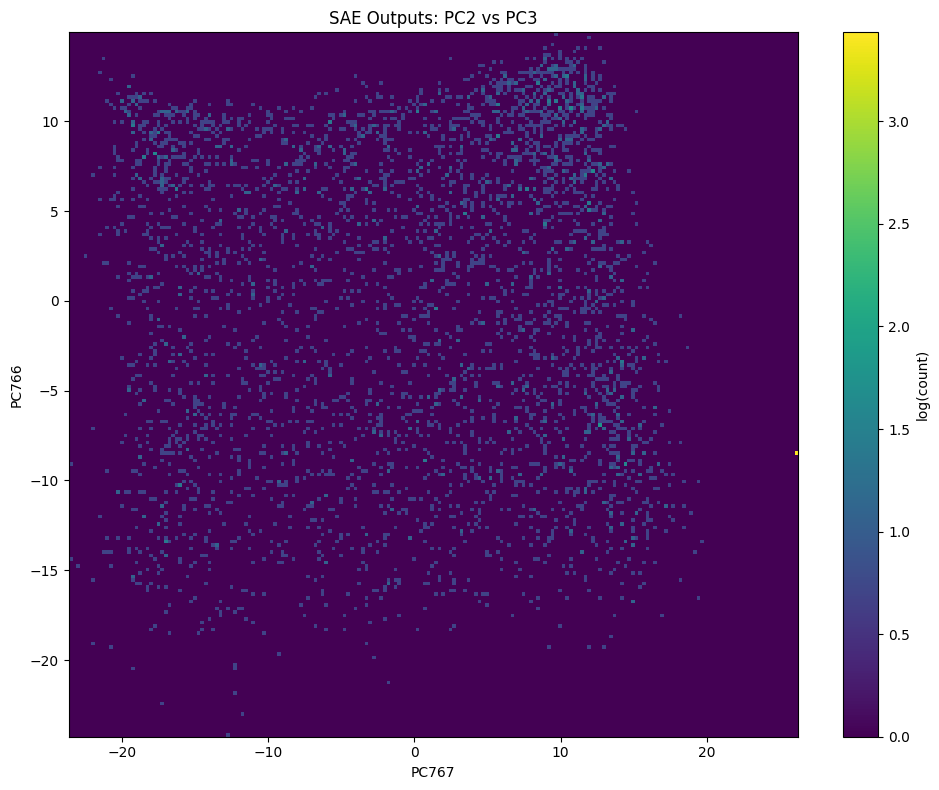

 17%|█▋        | 2/12 [00:09<00:46,  4.61s/it]

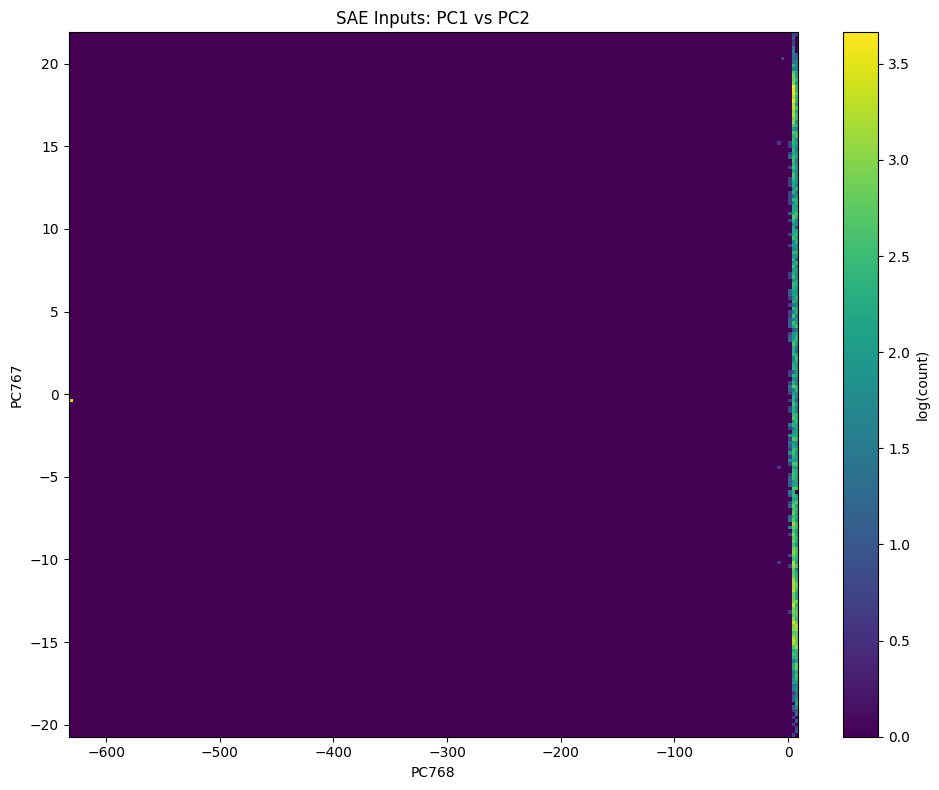

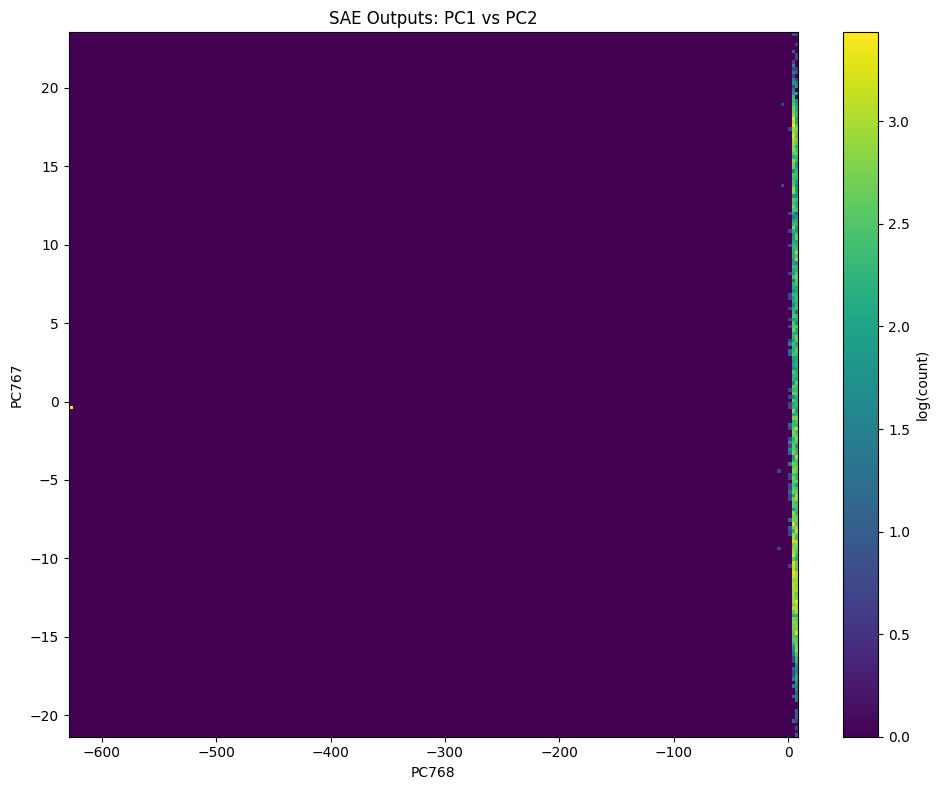

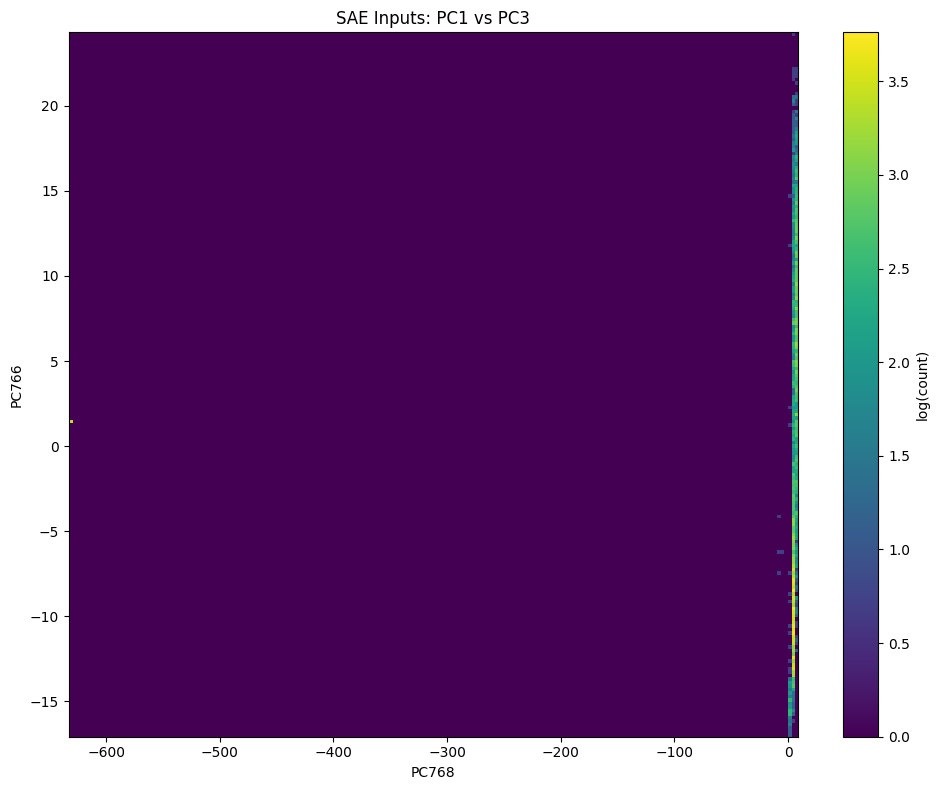

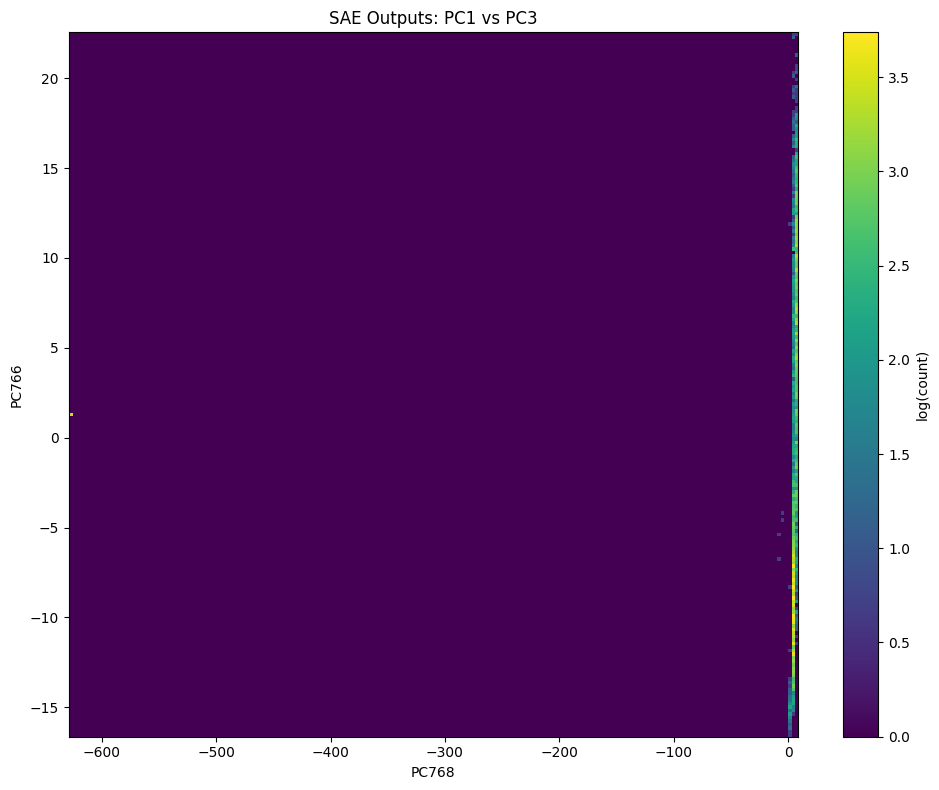

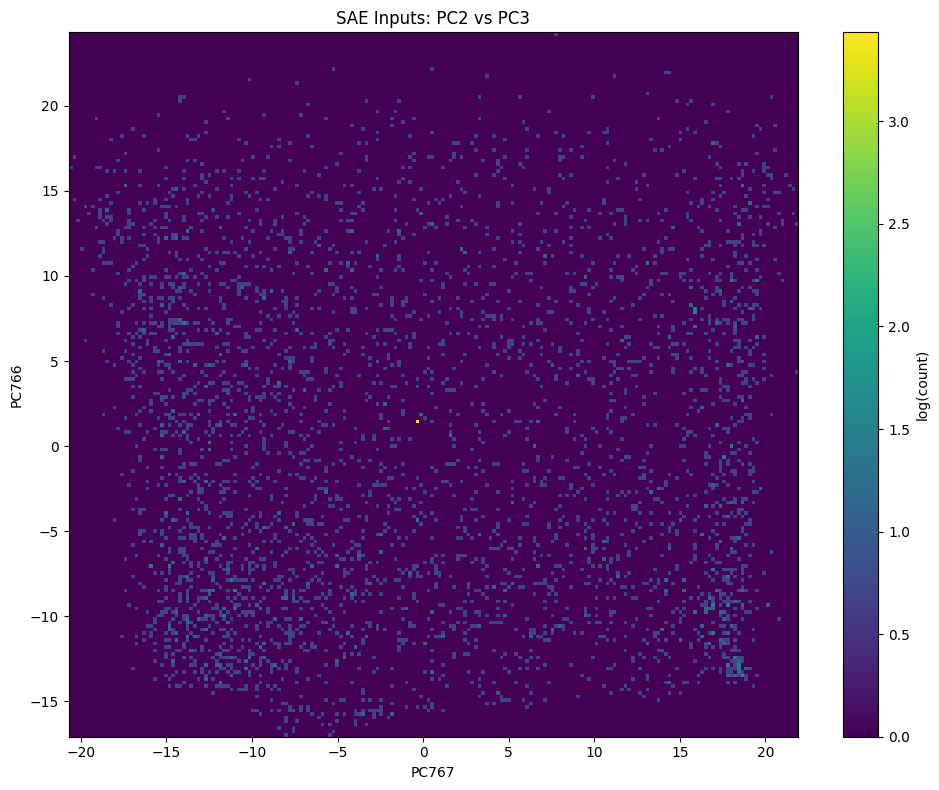

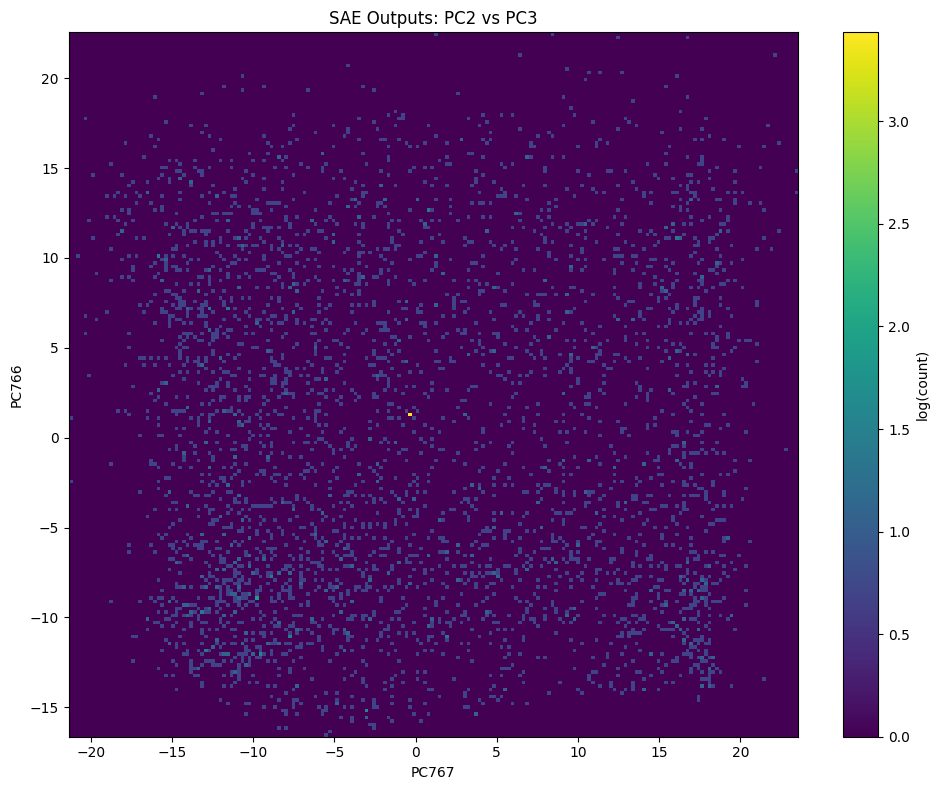

 25%|██▌       | 3/12 [00:13<00:41,  4.57s/it]

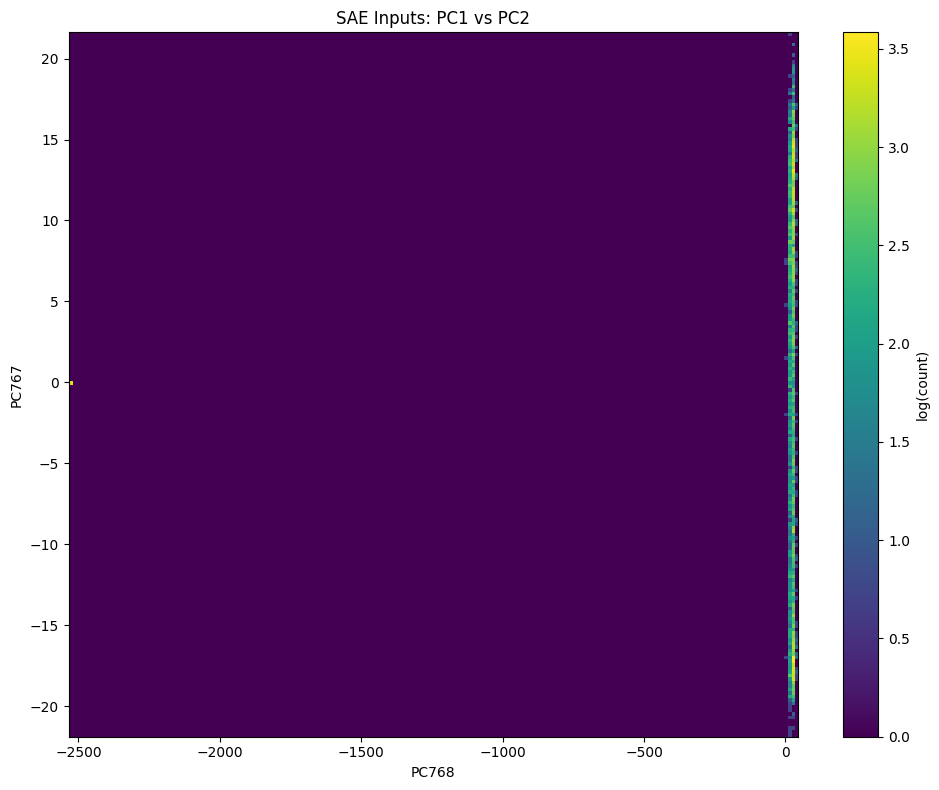

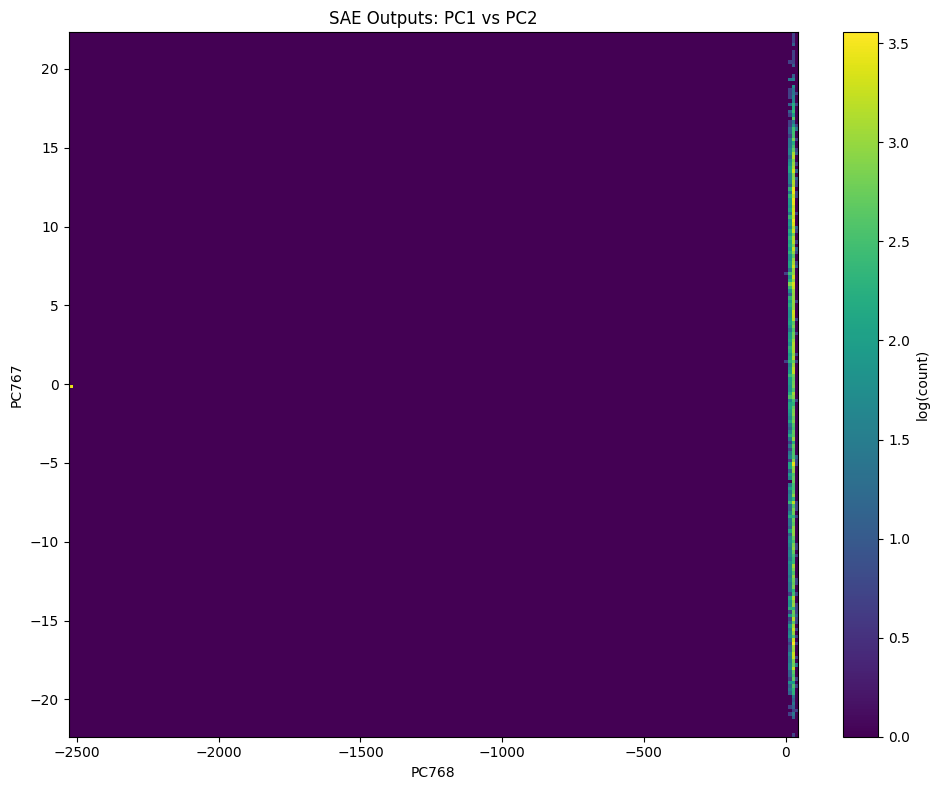

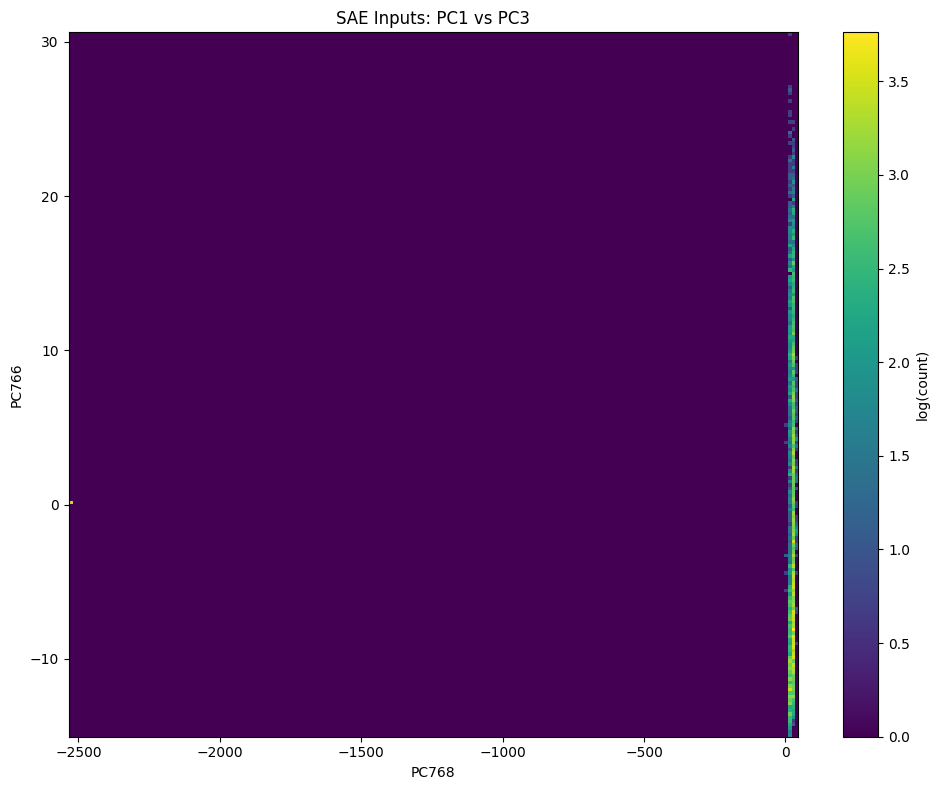

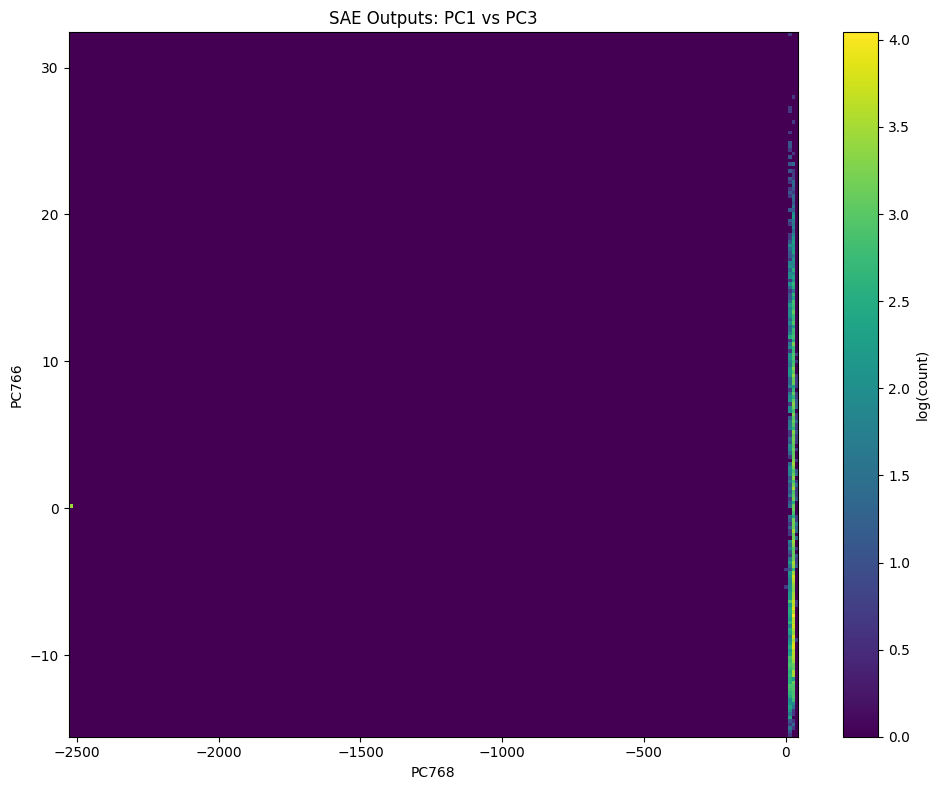

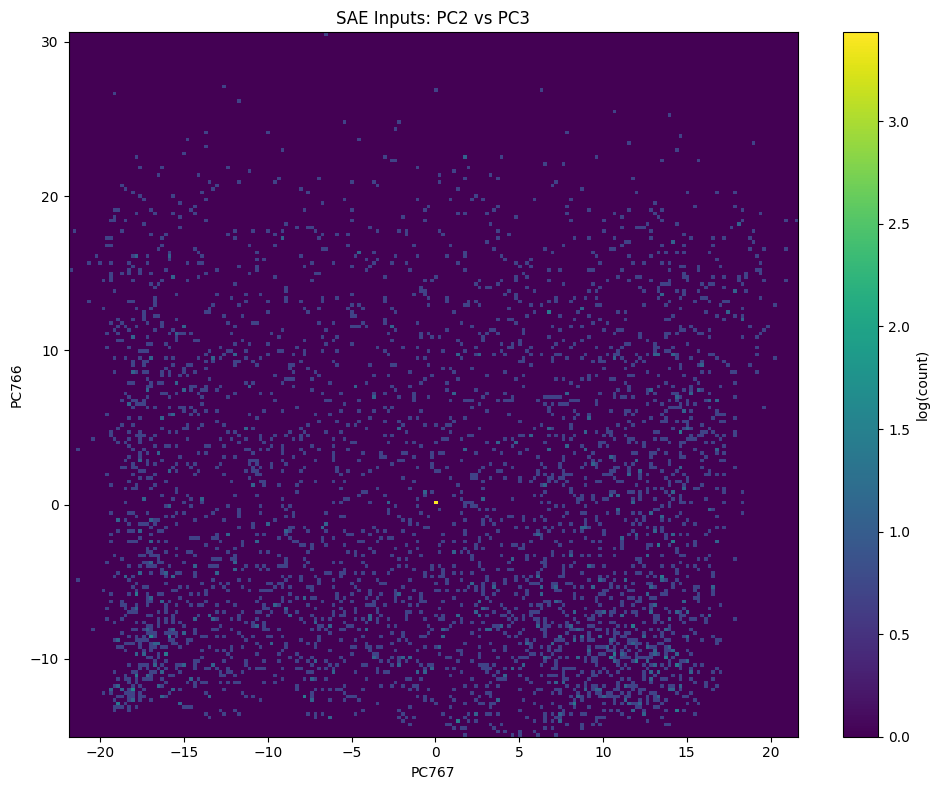

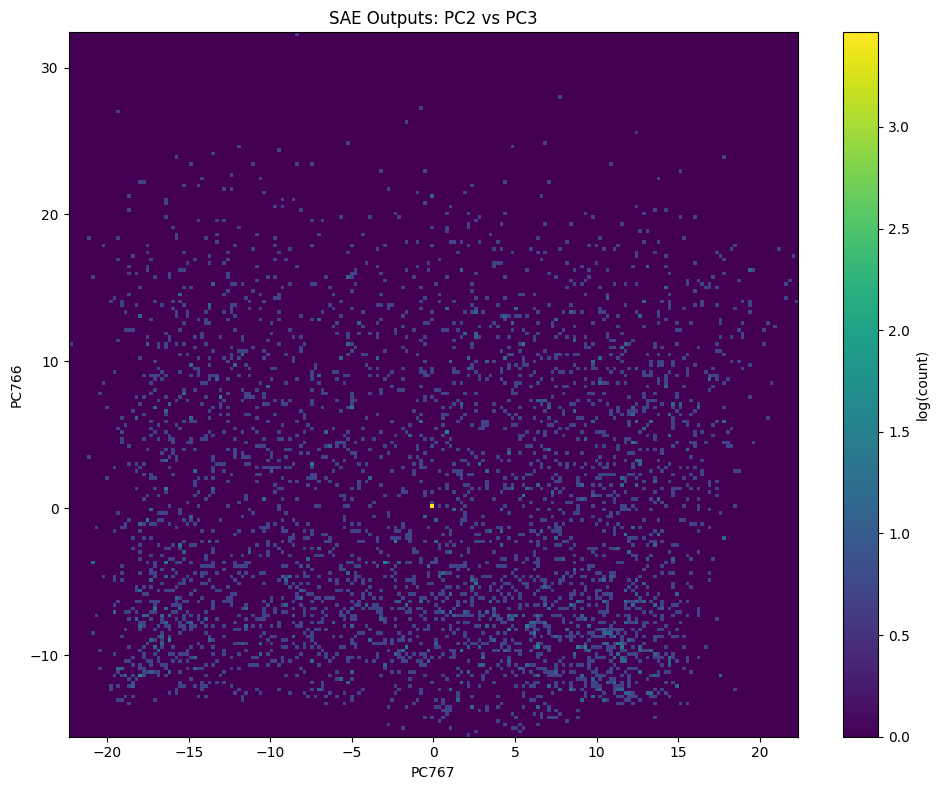

 33%|███▎      | 4/12 [00:18<00:36,  4.54s/it]

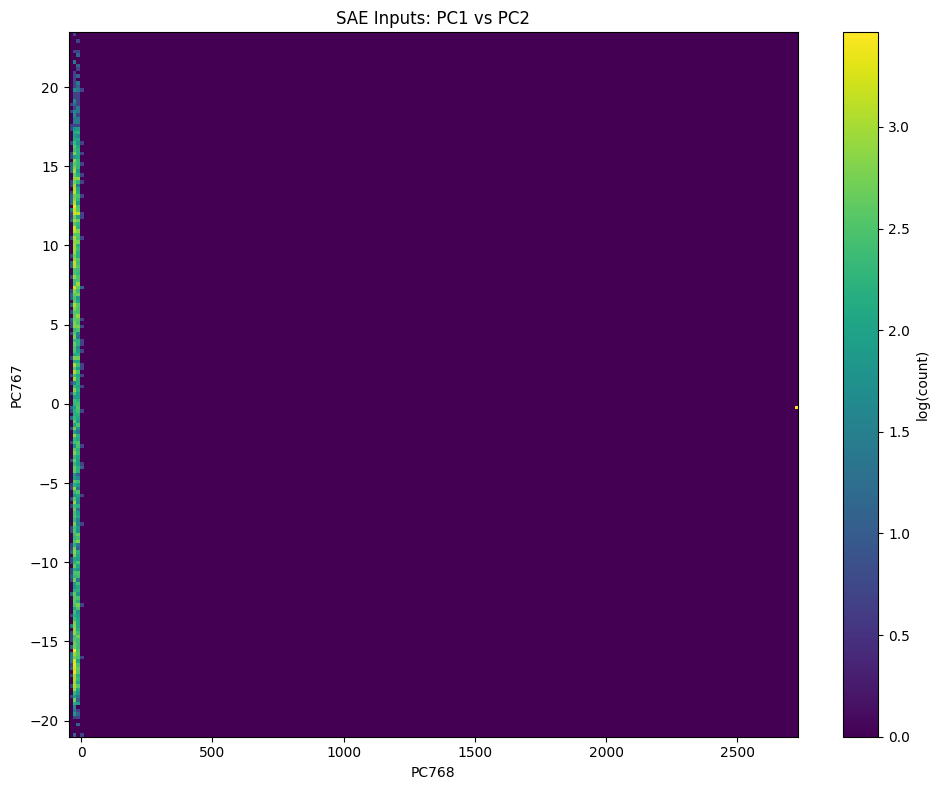

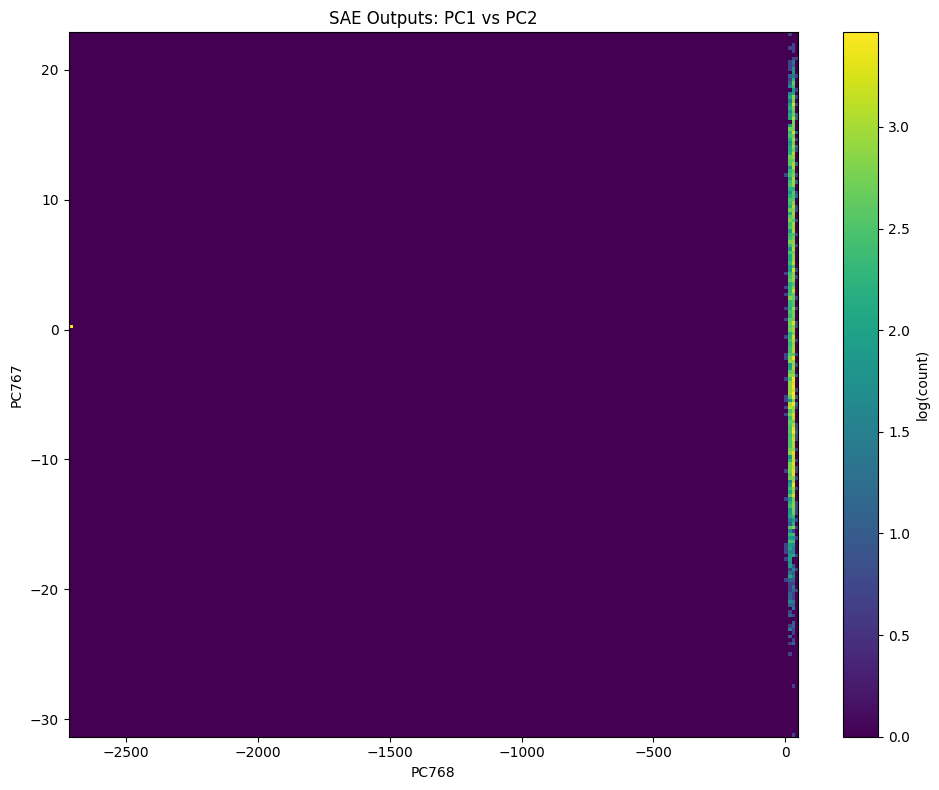

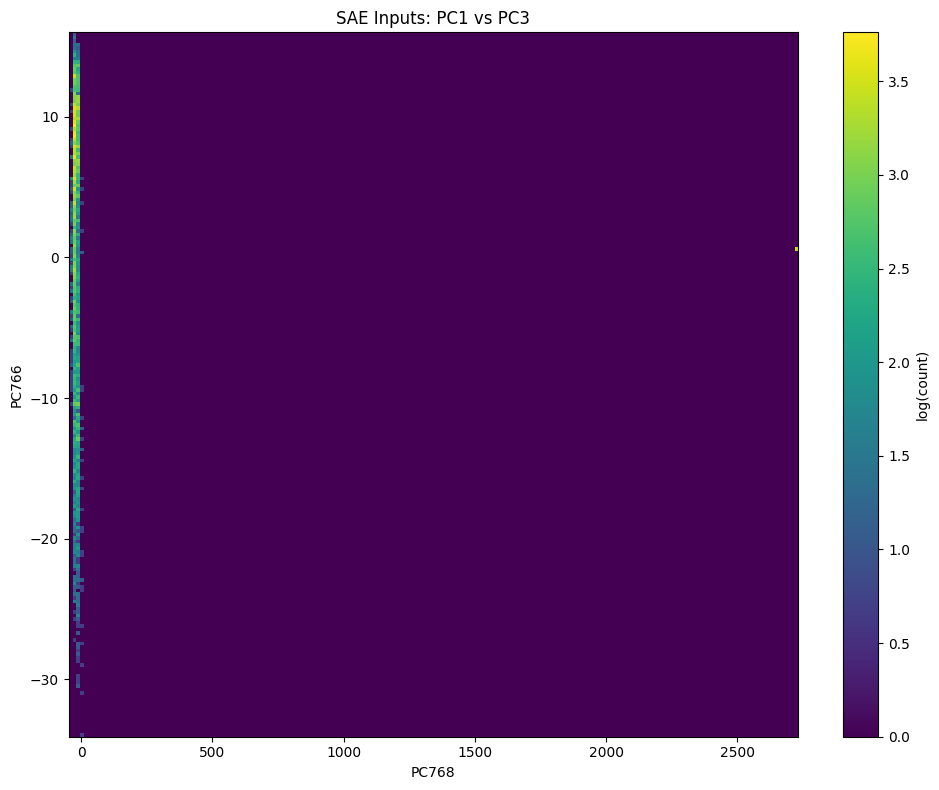

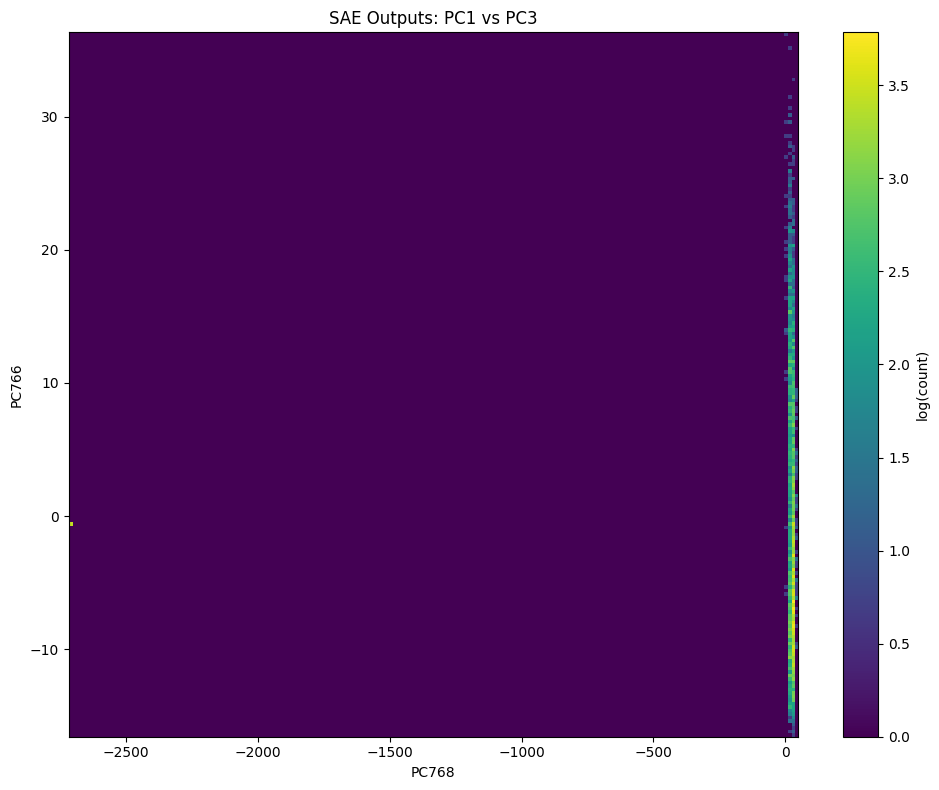

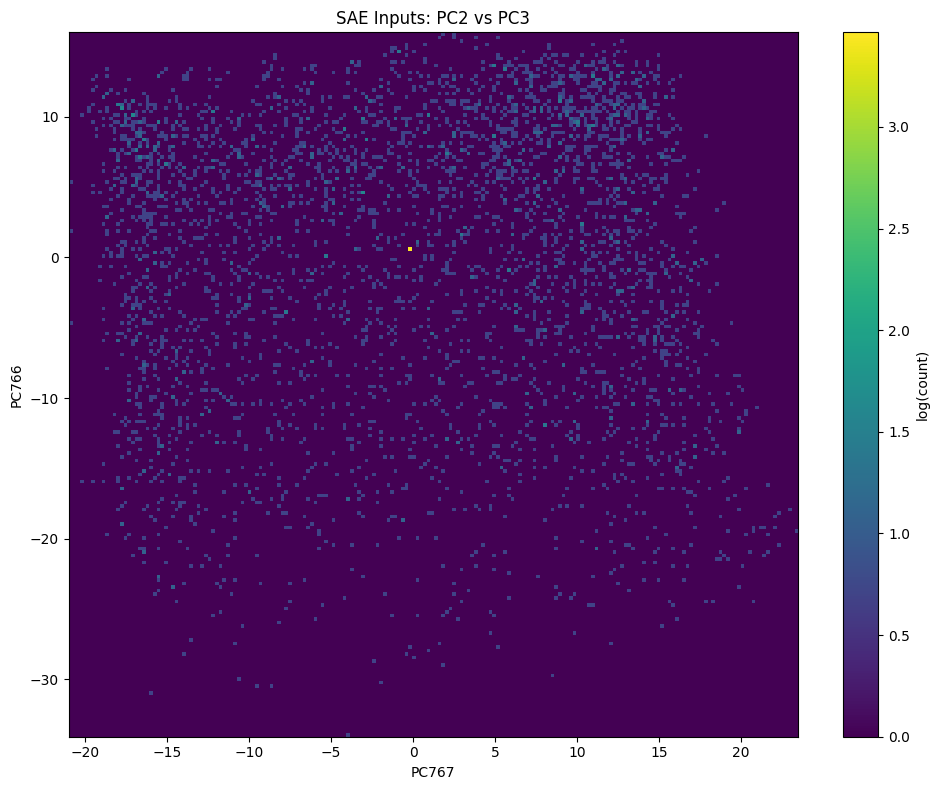

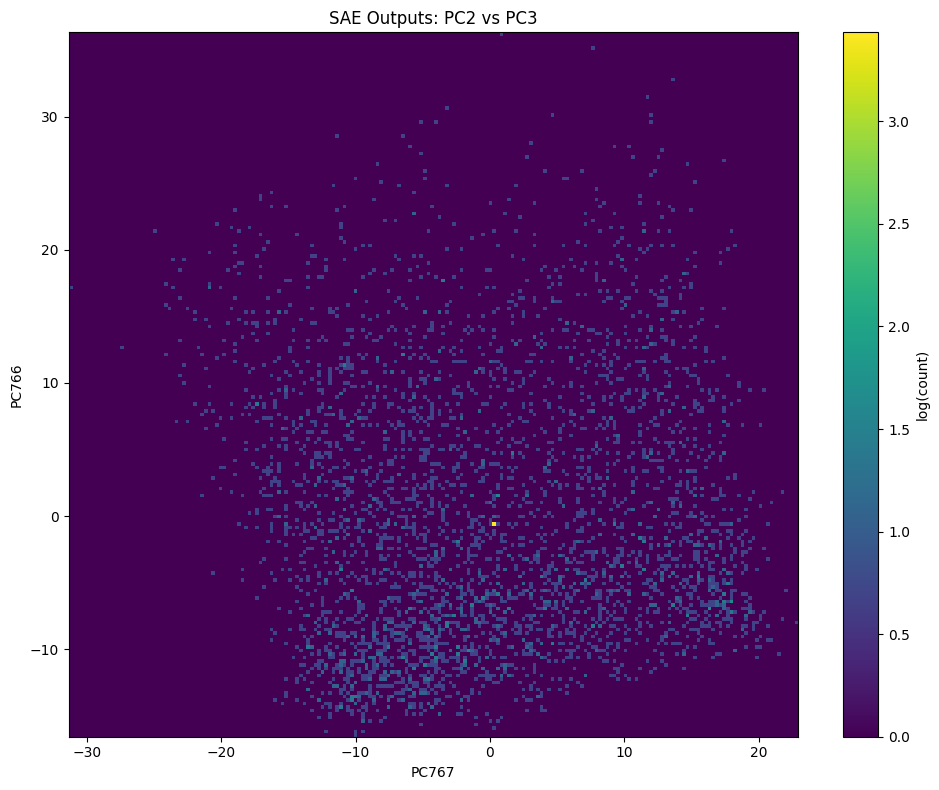

 42%|████▏     | 5/12 [00:22<00:31,  4.49s/it]

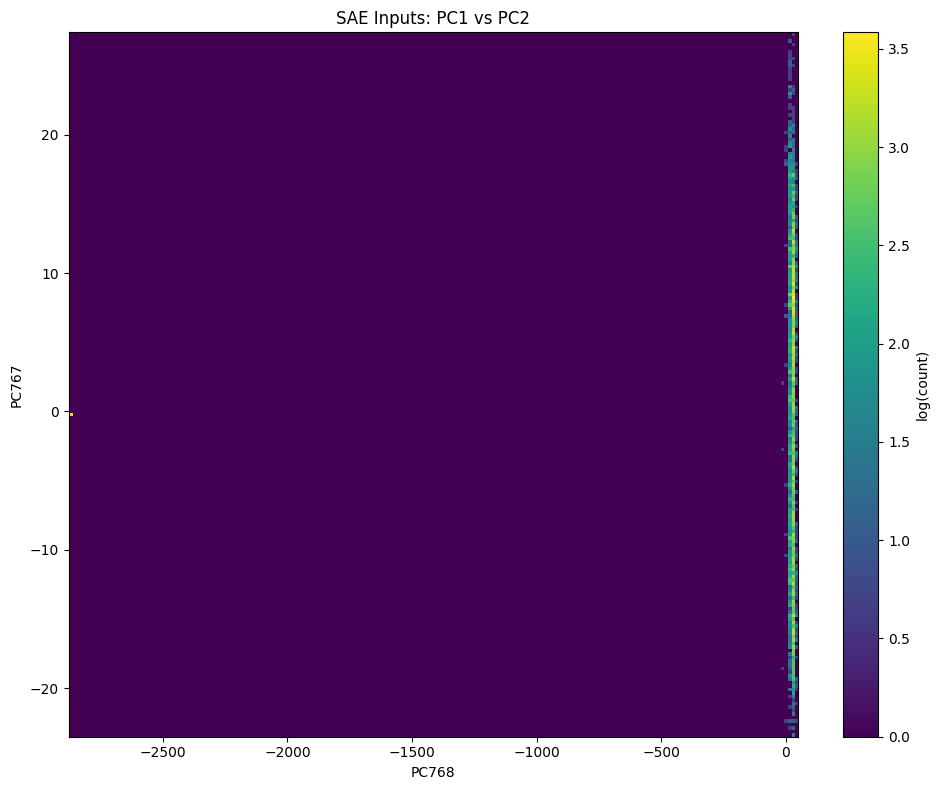

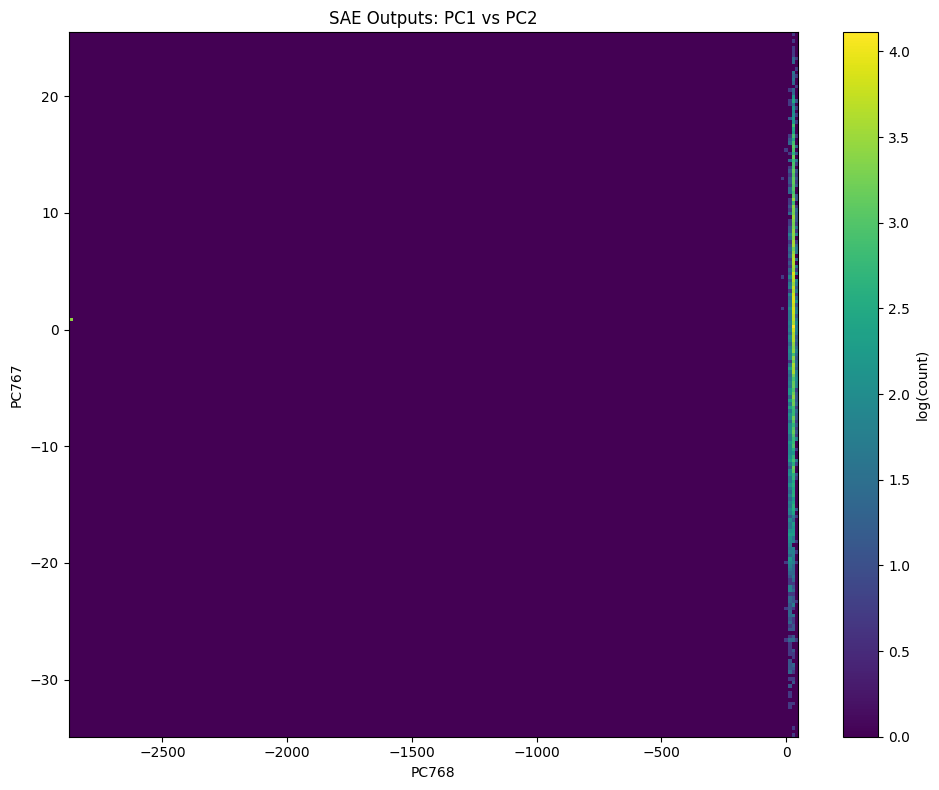

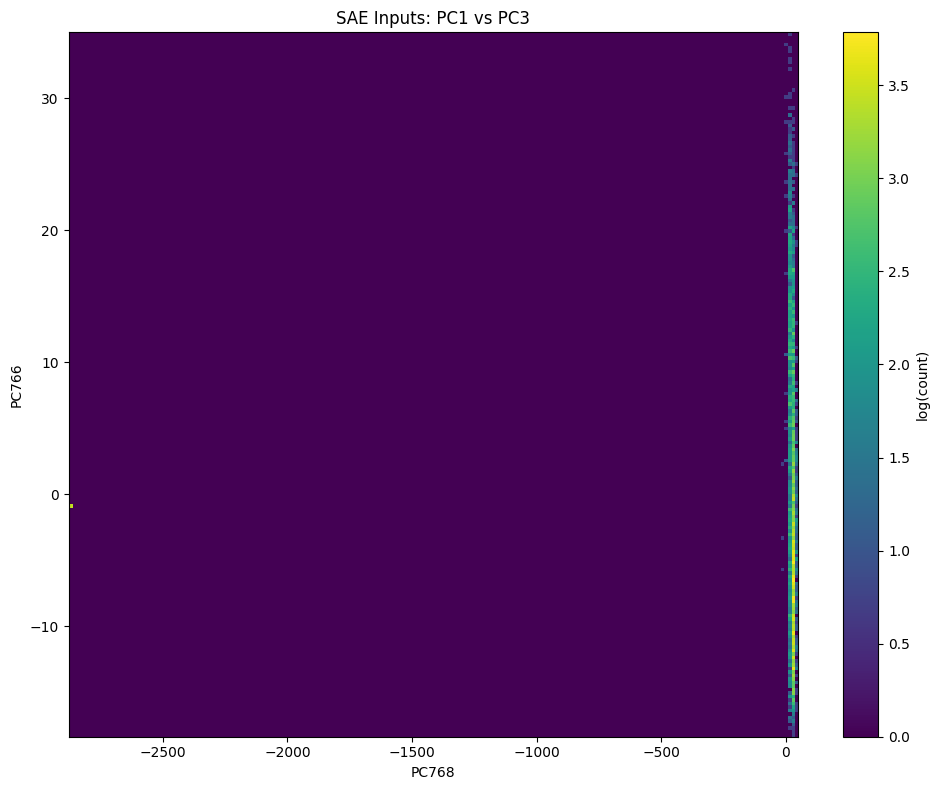

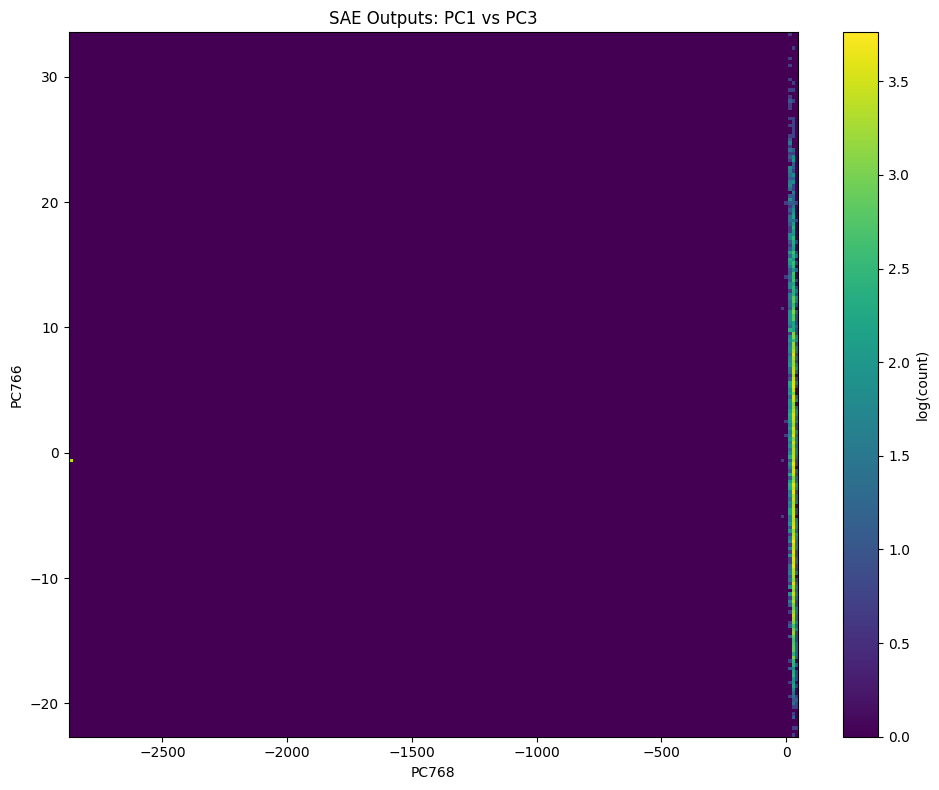

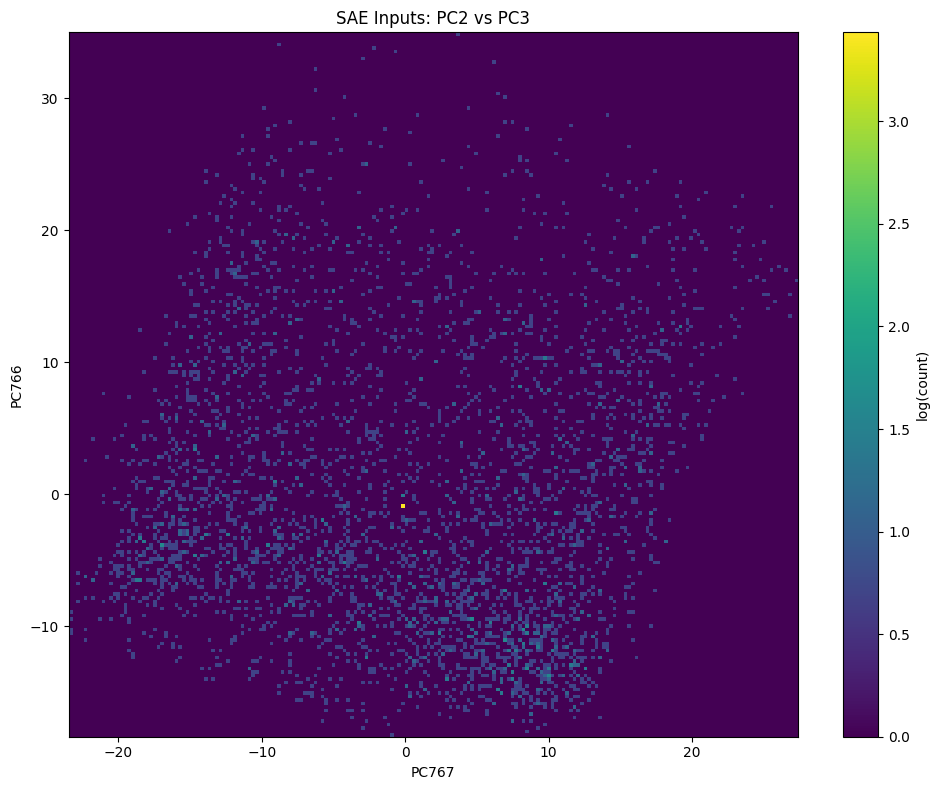

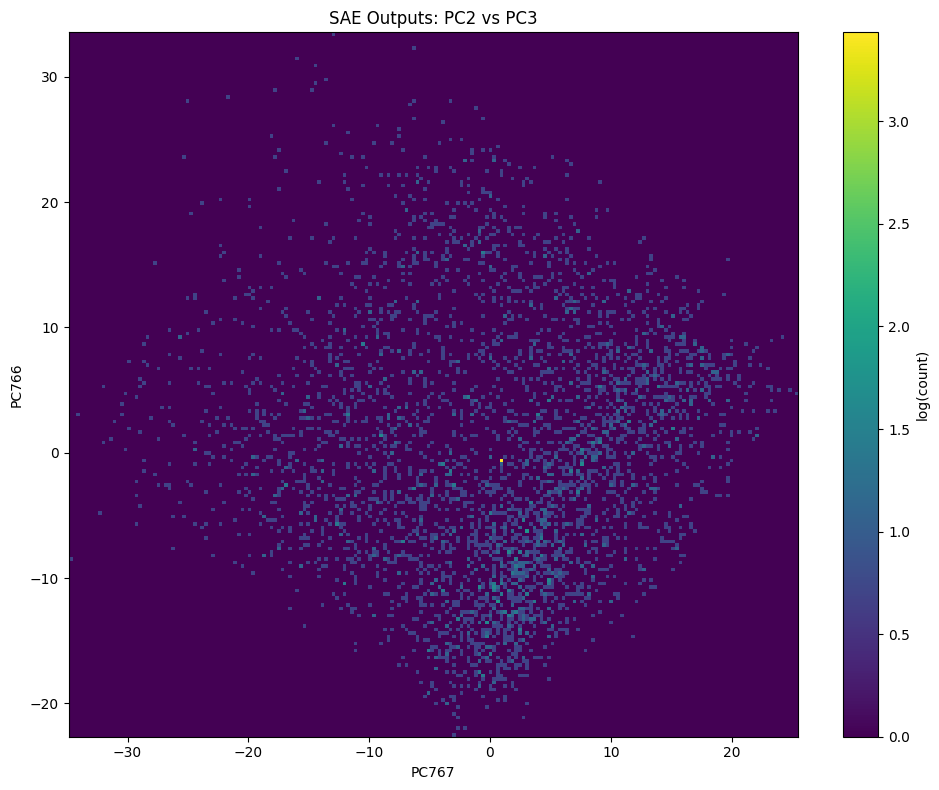

 50%|█████     | 6/12 [00:26<00:26,  4.46s/it]

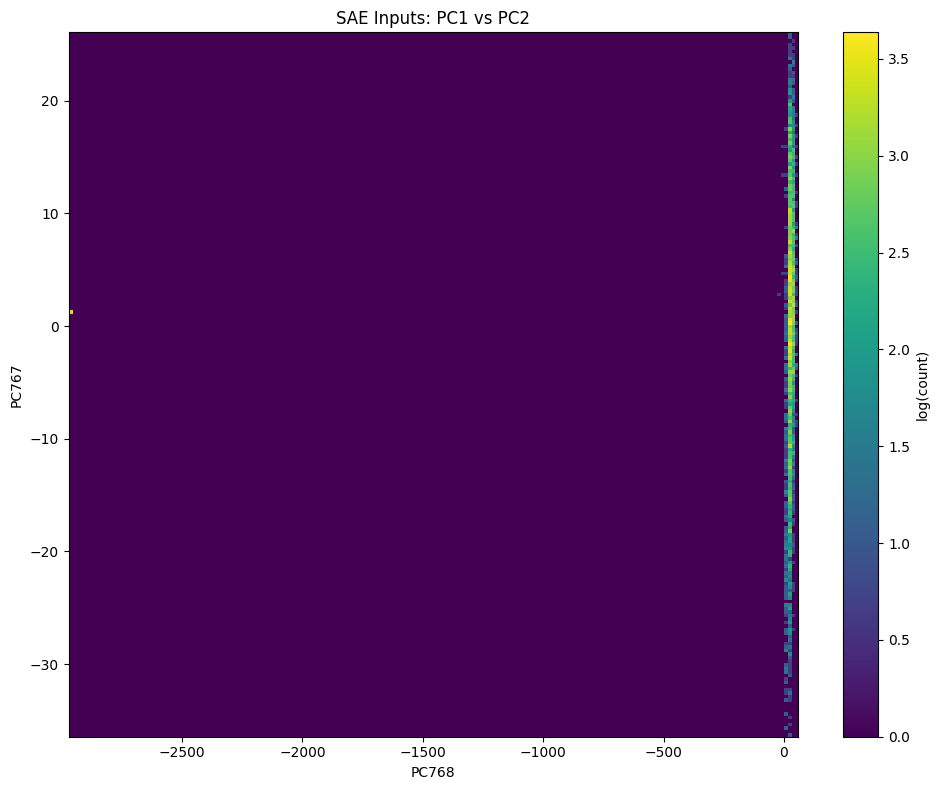

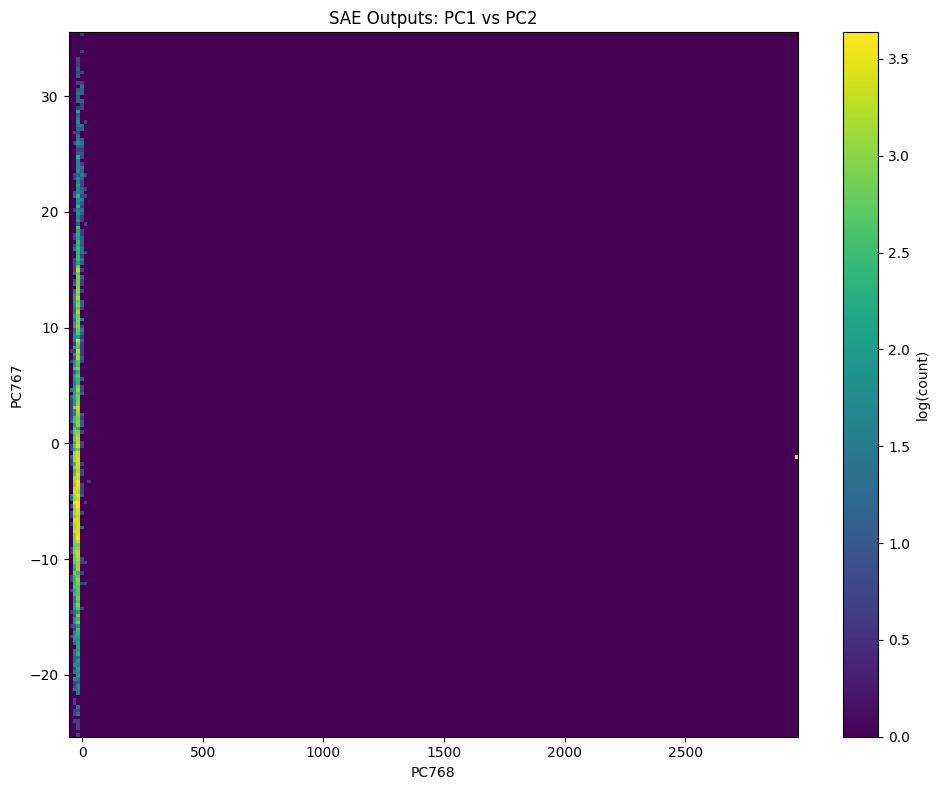

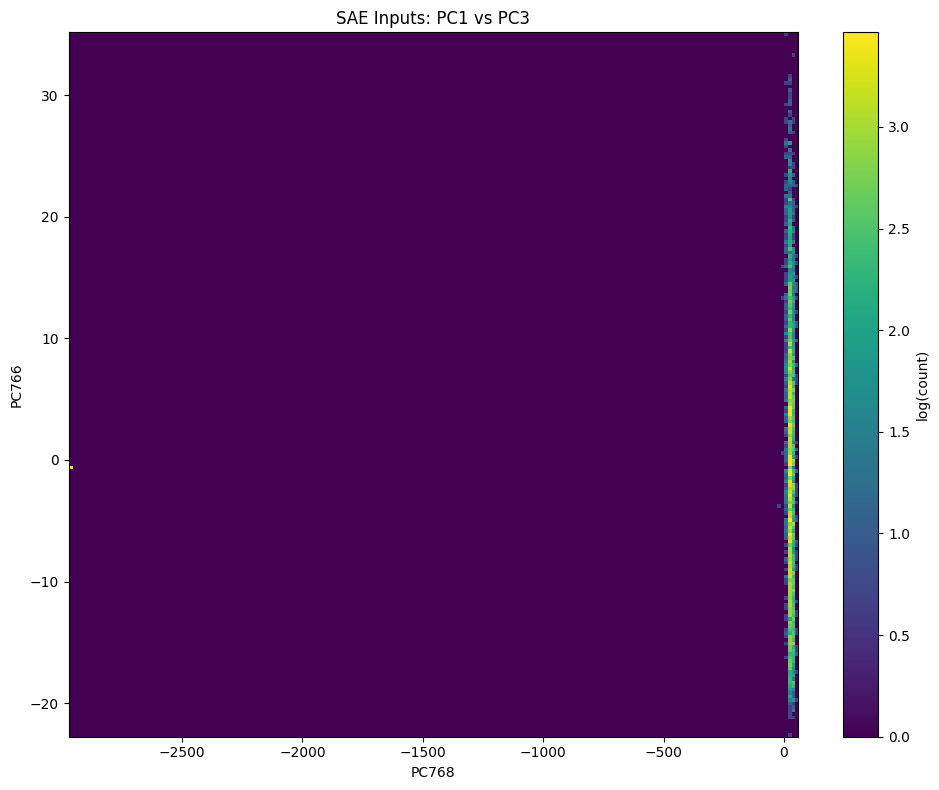

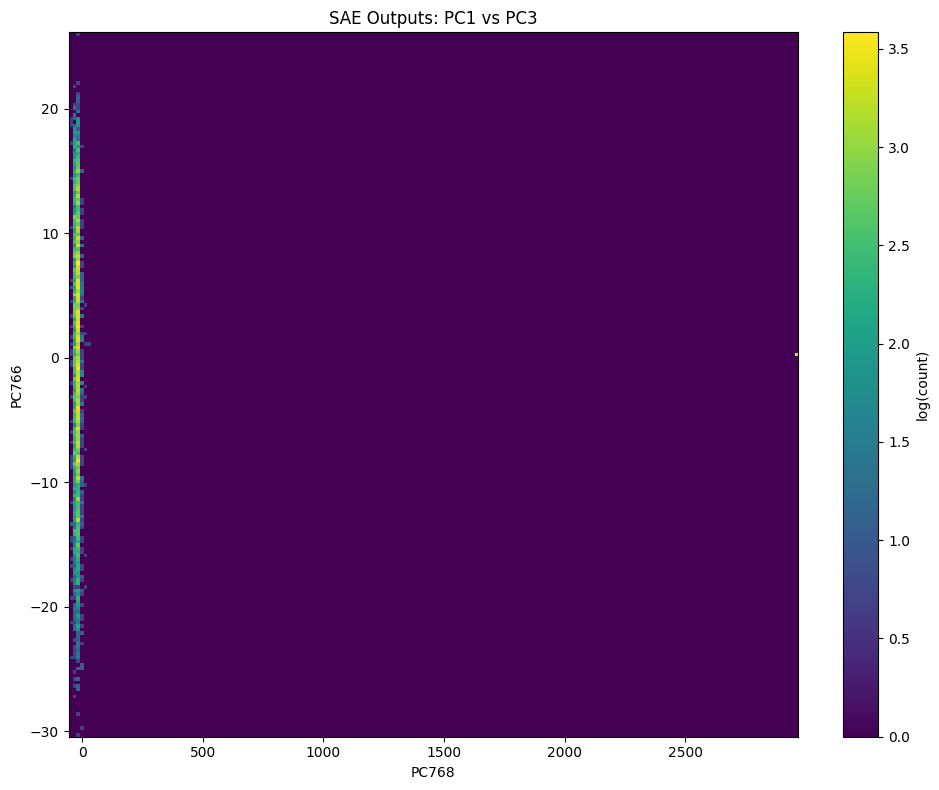

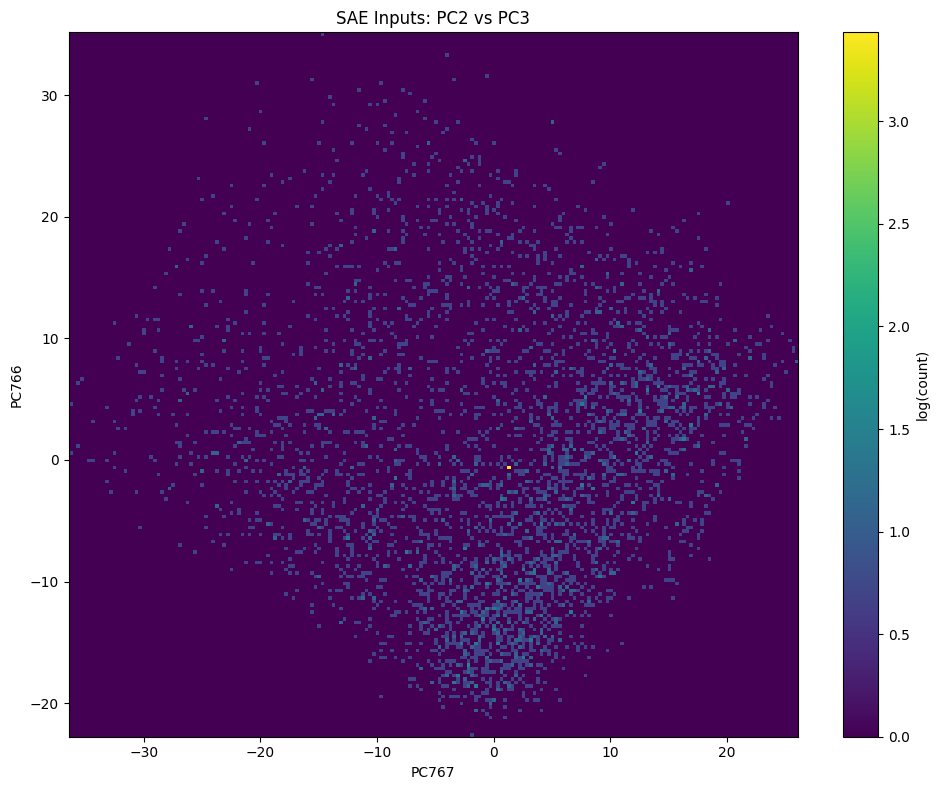

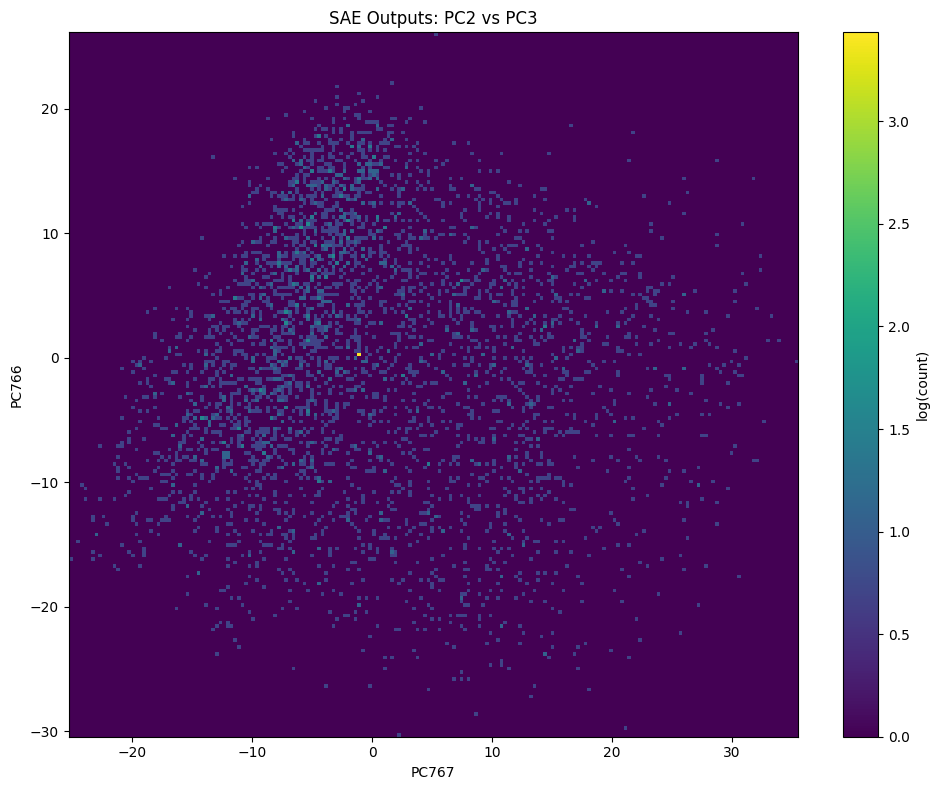

 58%|█████▊    | 7/12 [00:31<00:22,  4.56s/it]

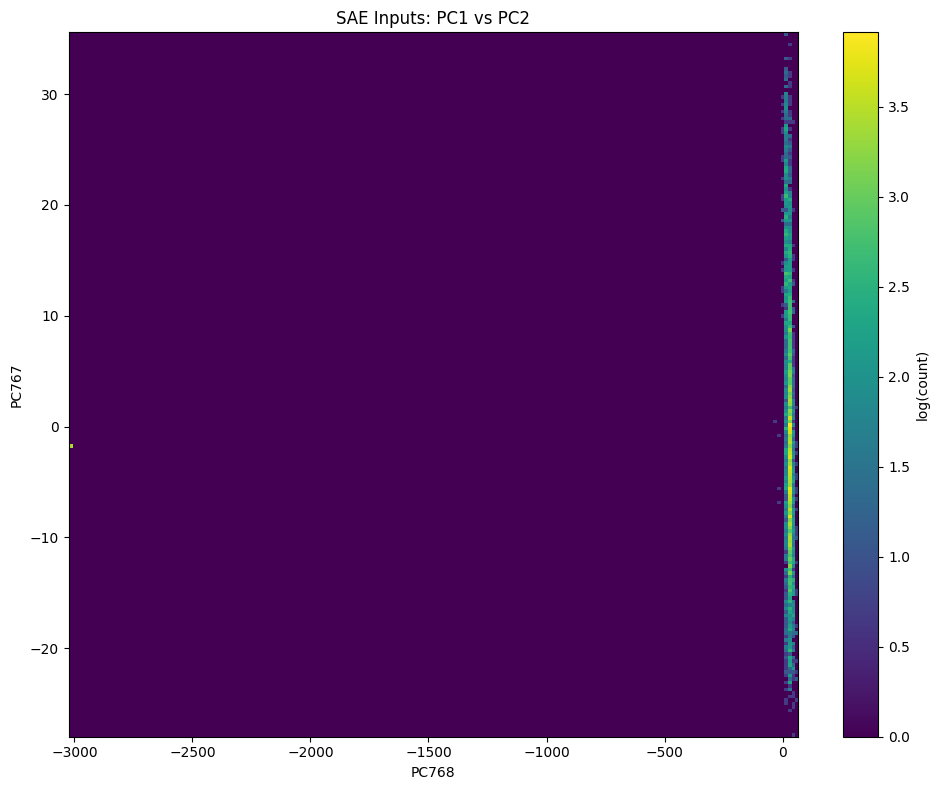

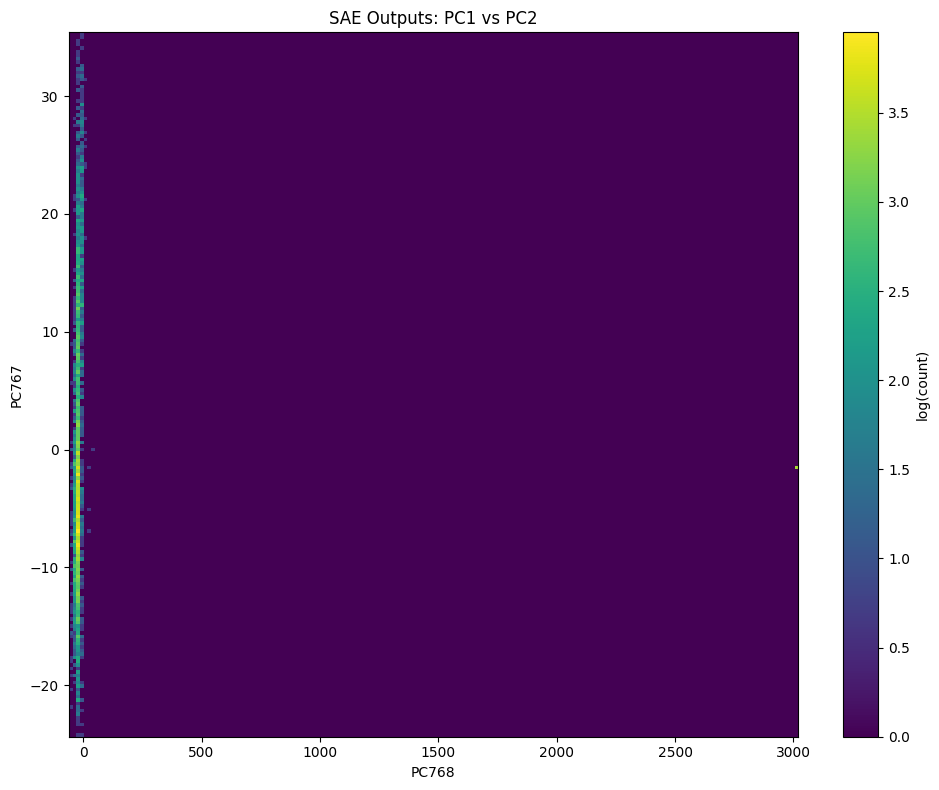

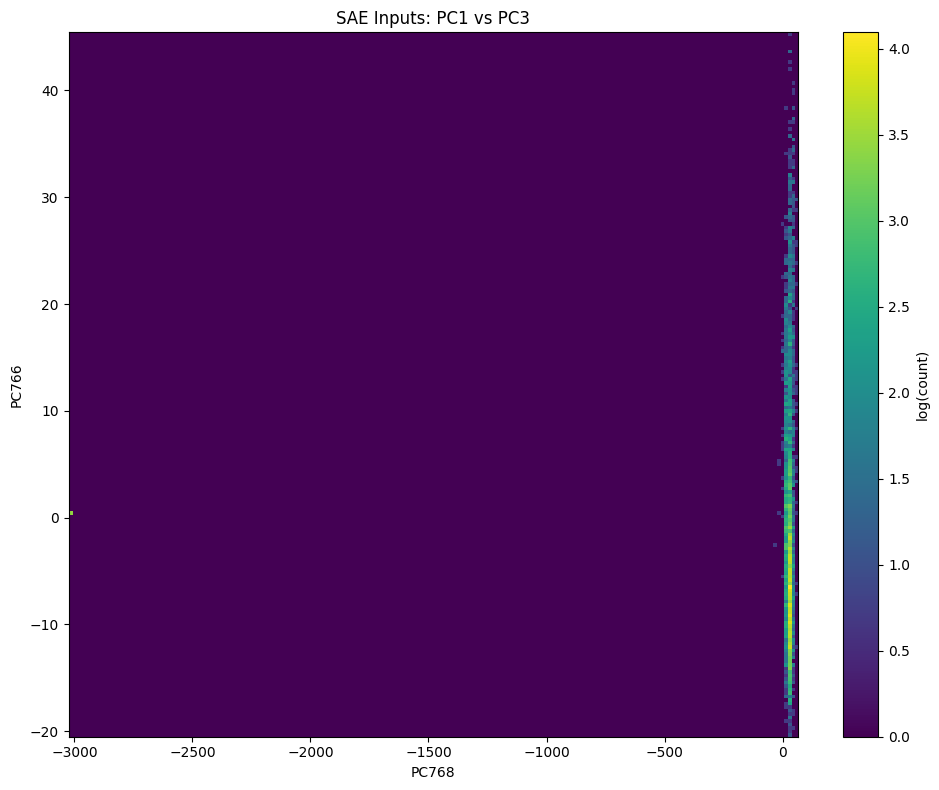

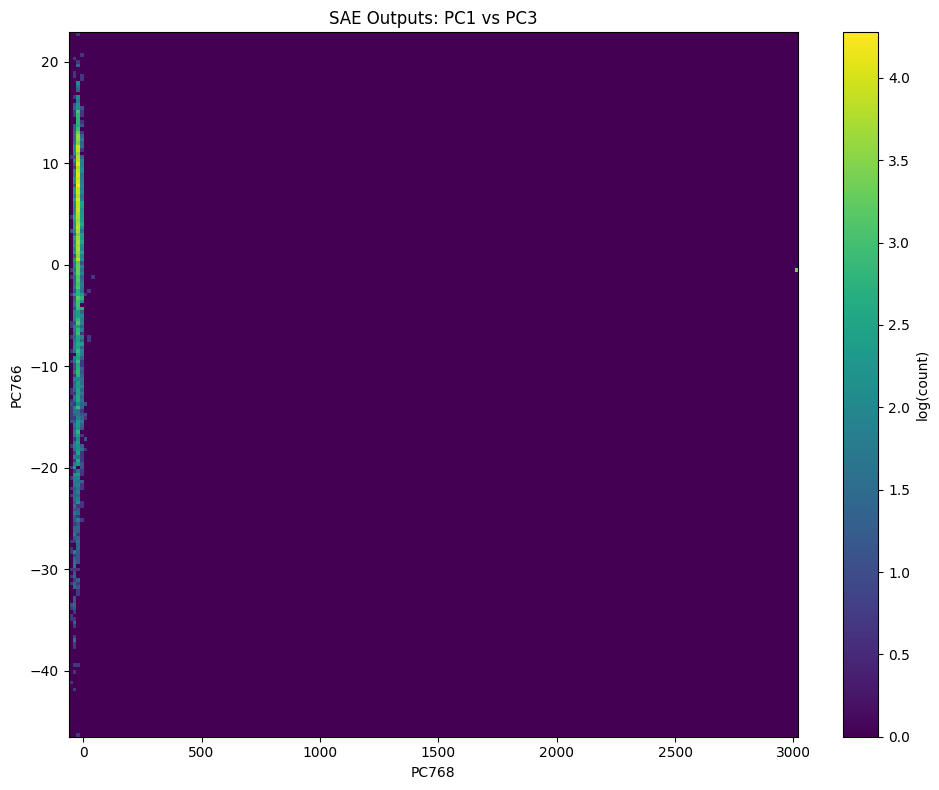

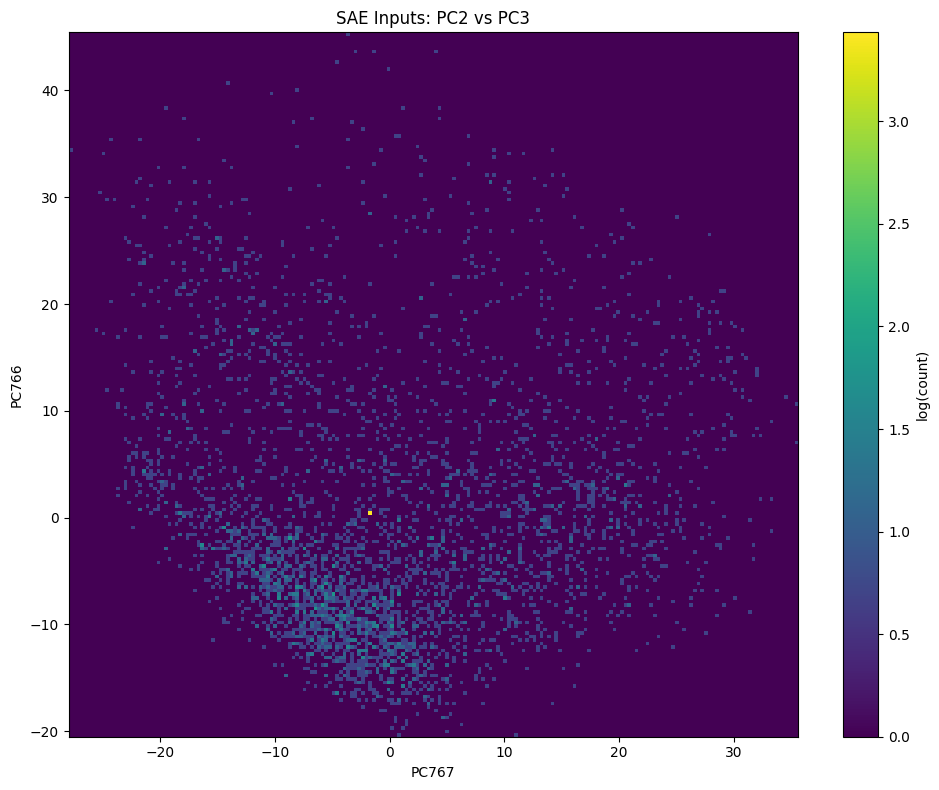

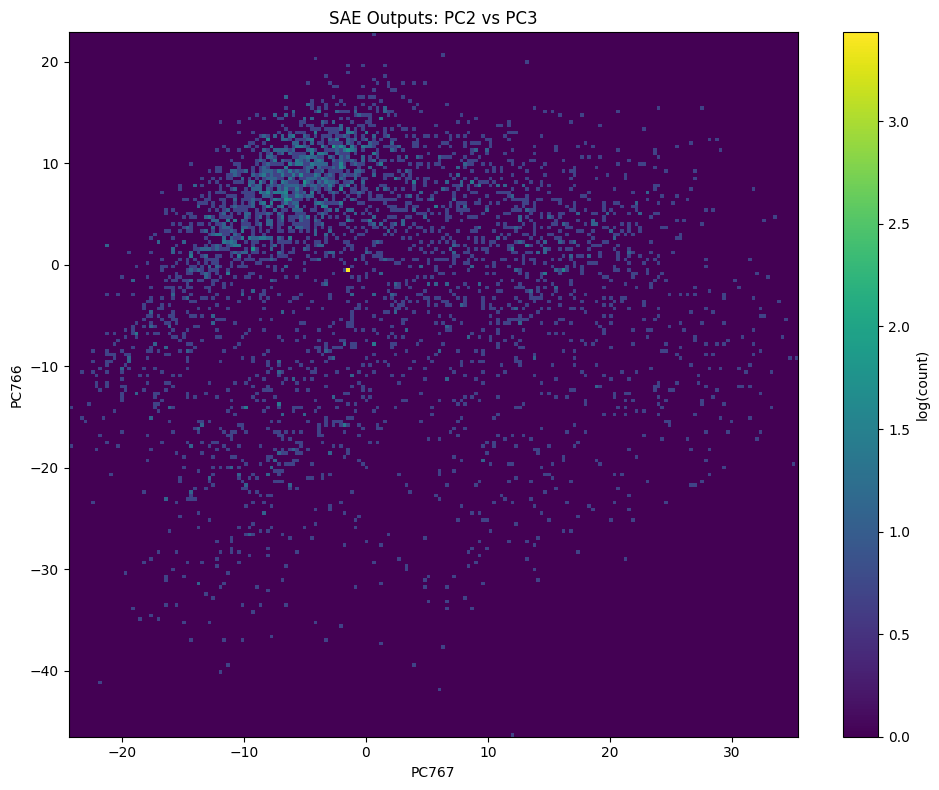

 67%|██████▋   | 8/12 [00:36<00:18,  4.54s/it]

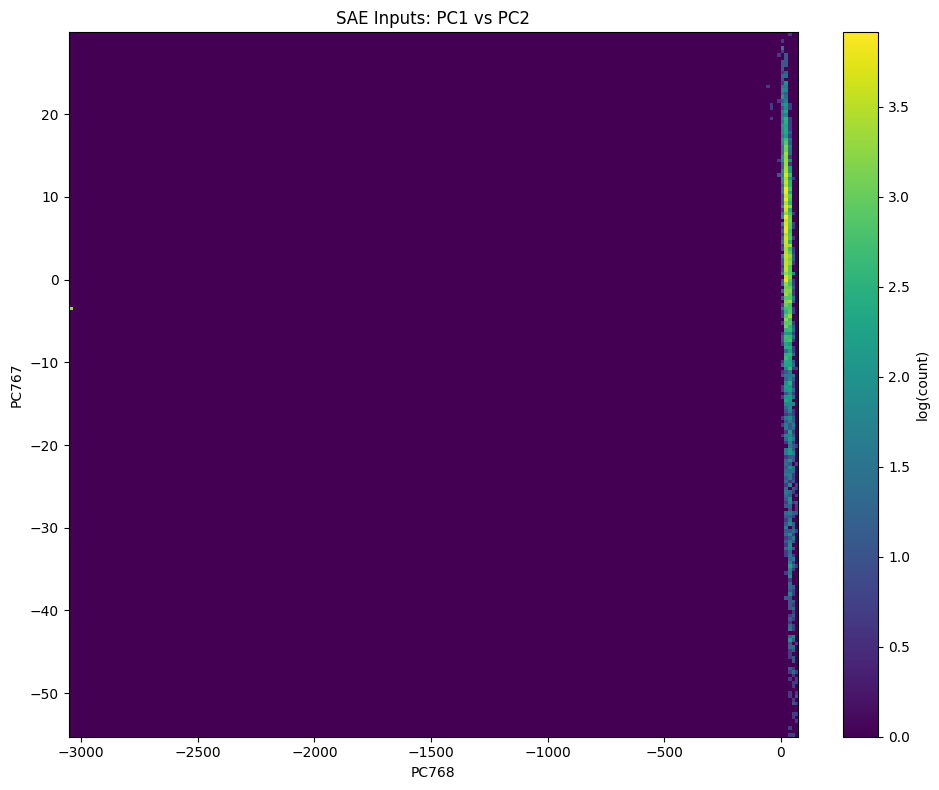

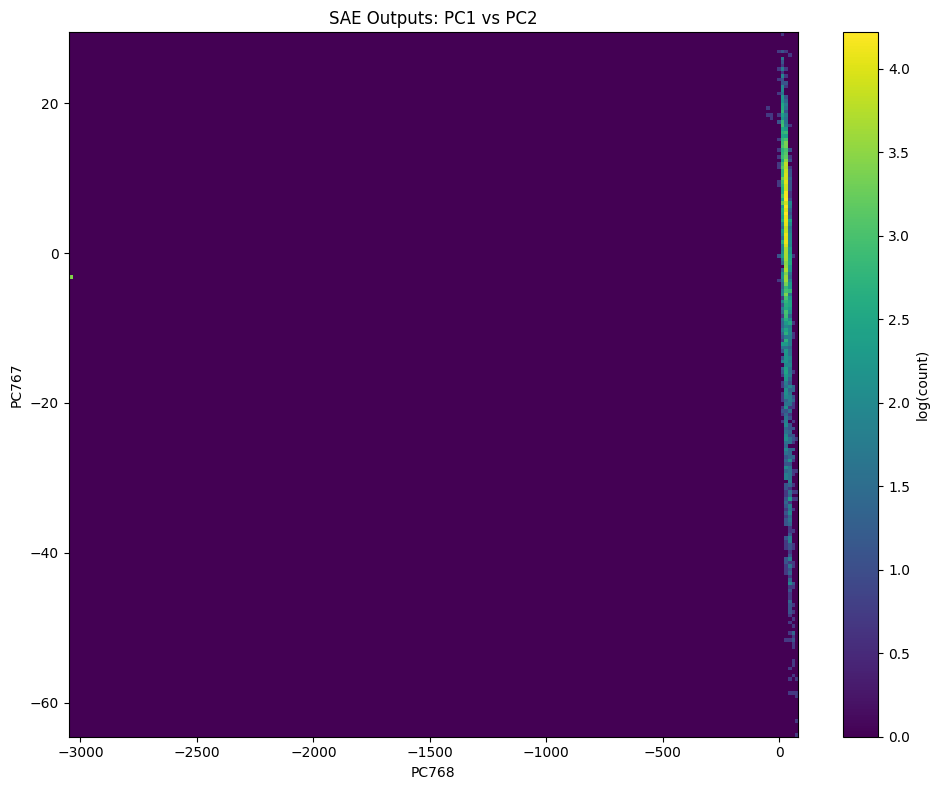

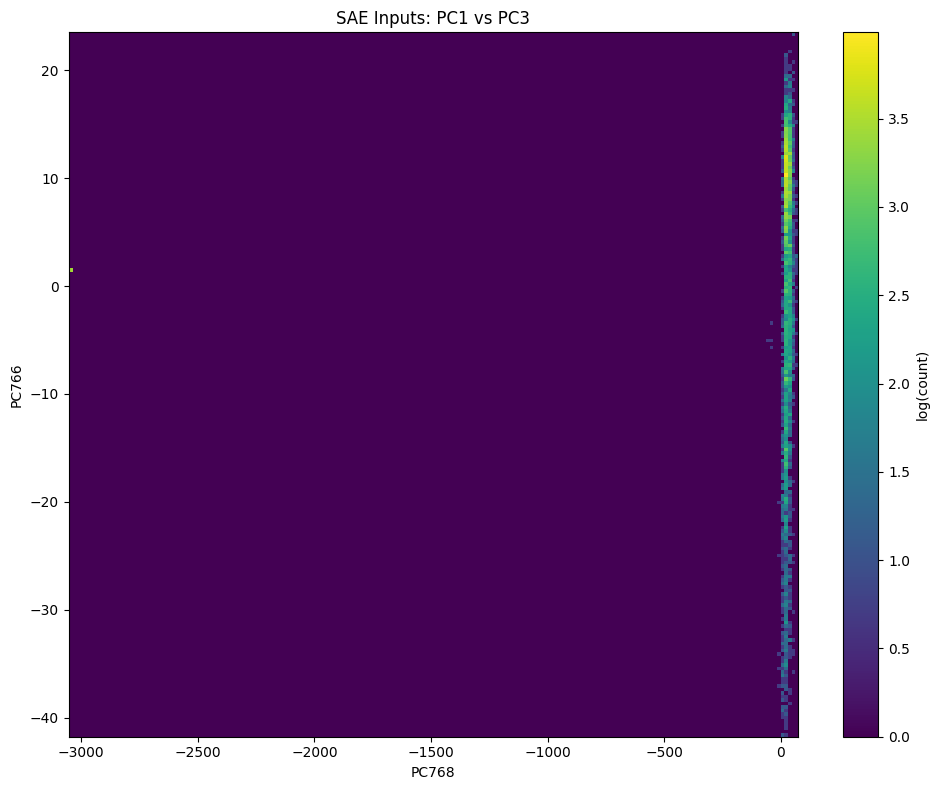

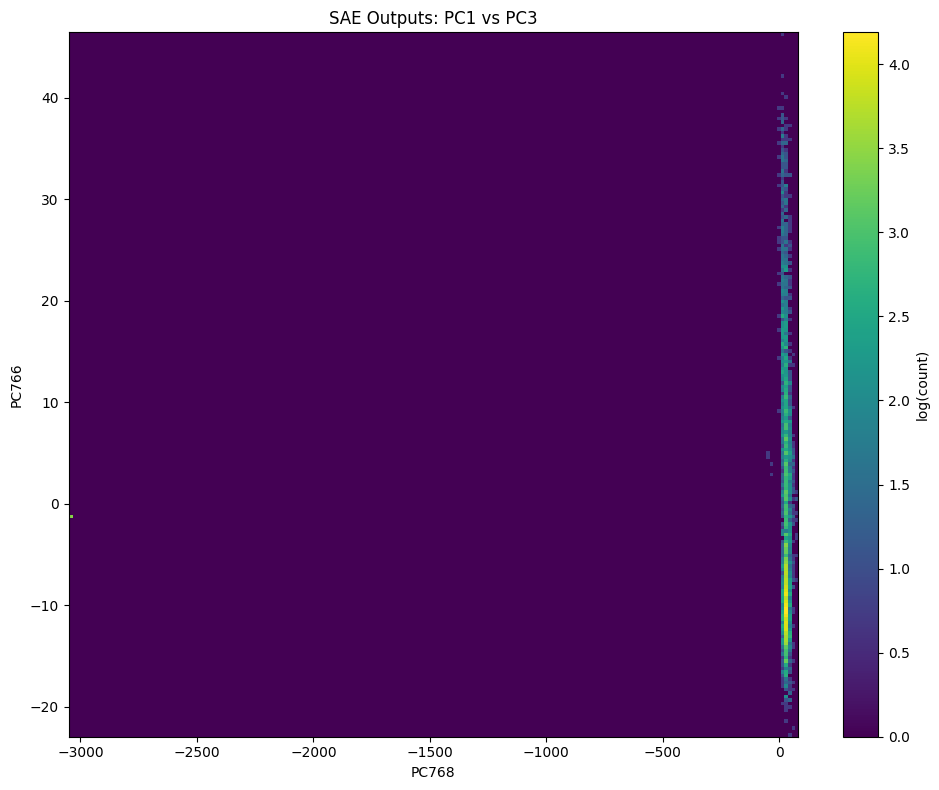

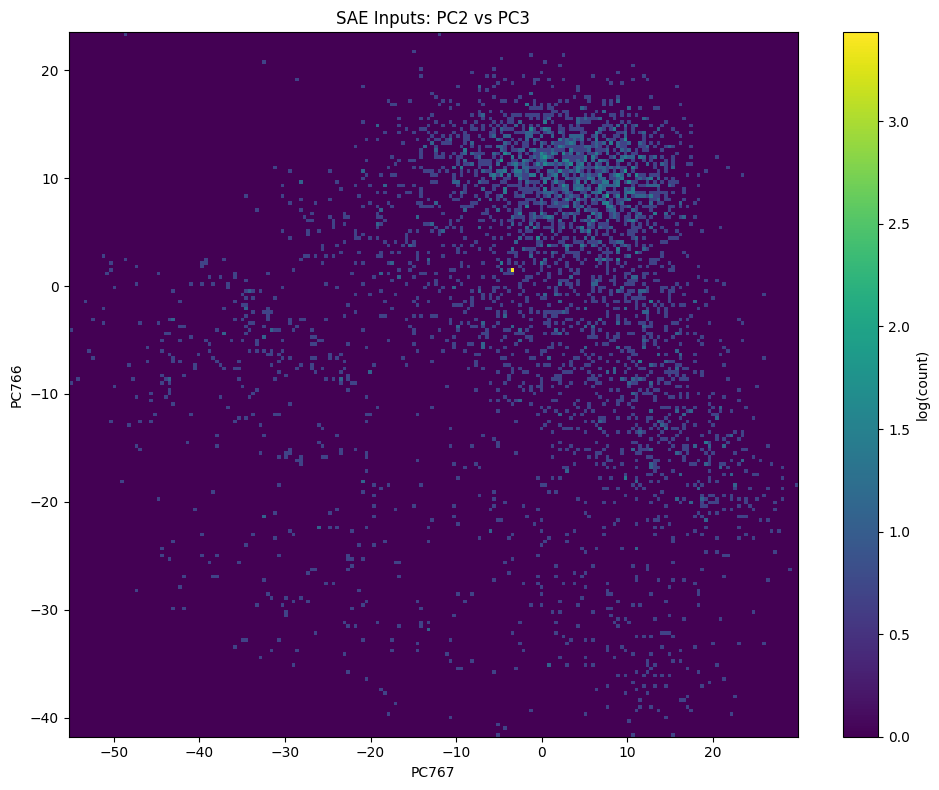

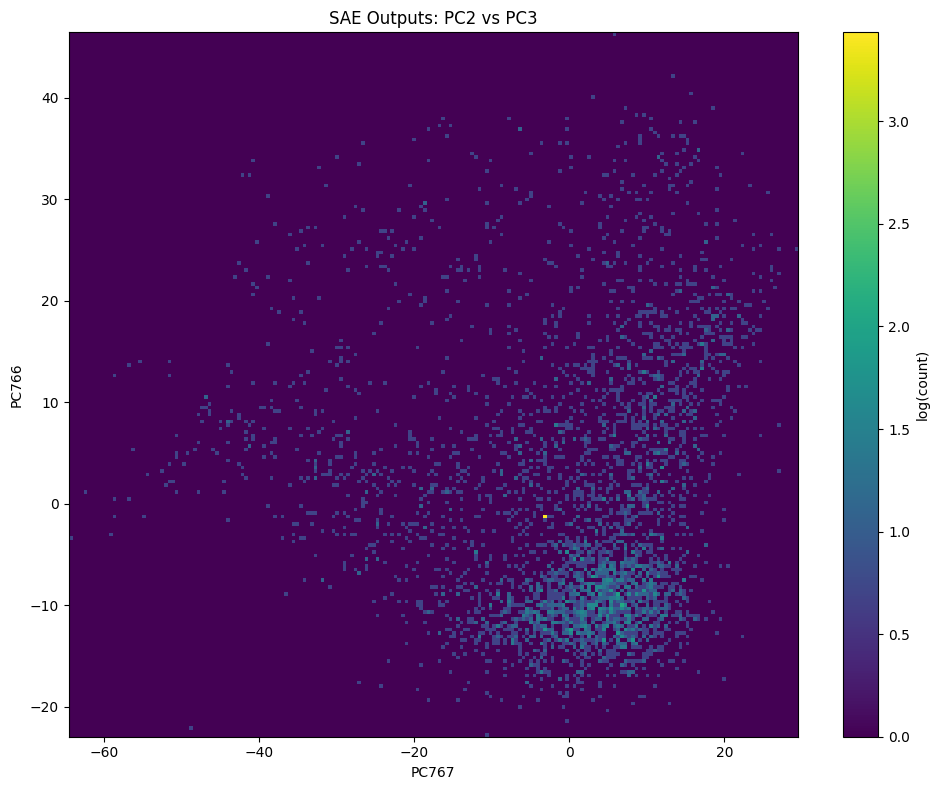

 75%|███████▌  | 9/12 [00:40<00:13,  4.51s/it]

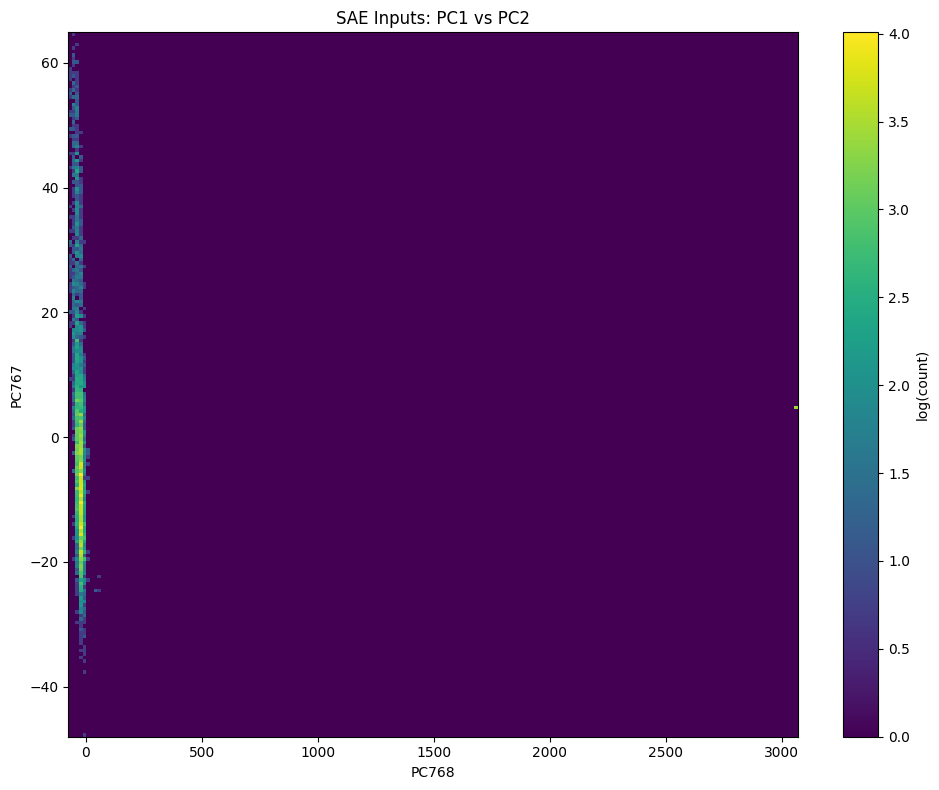

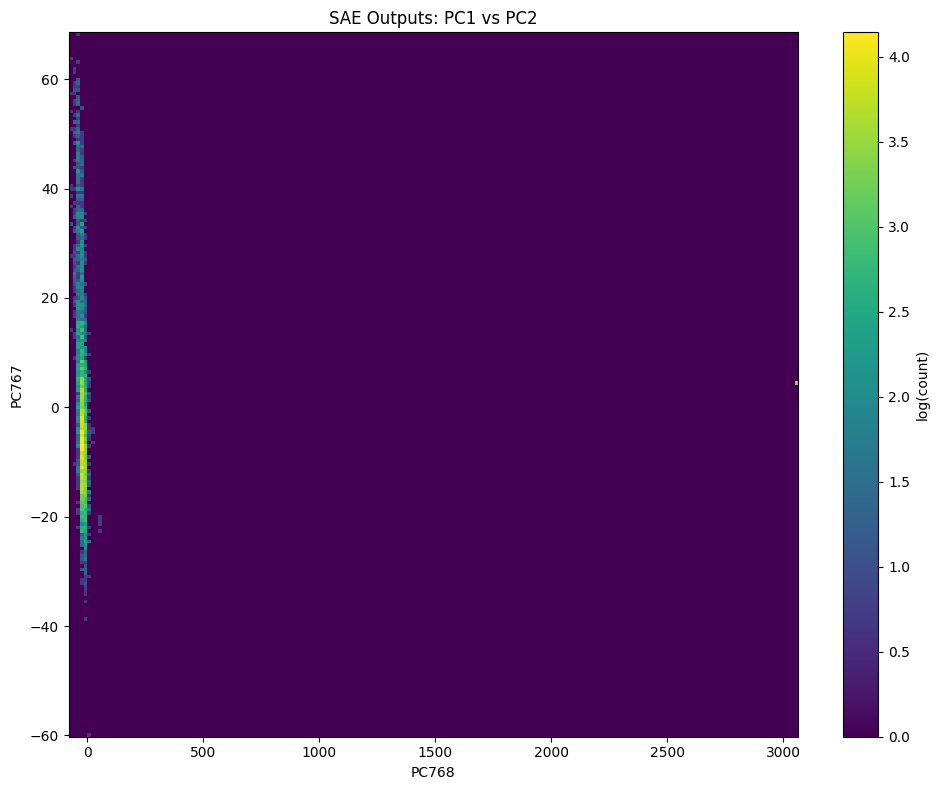

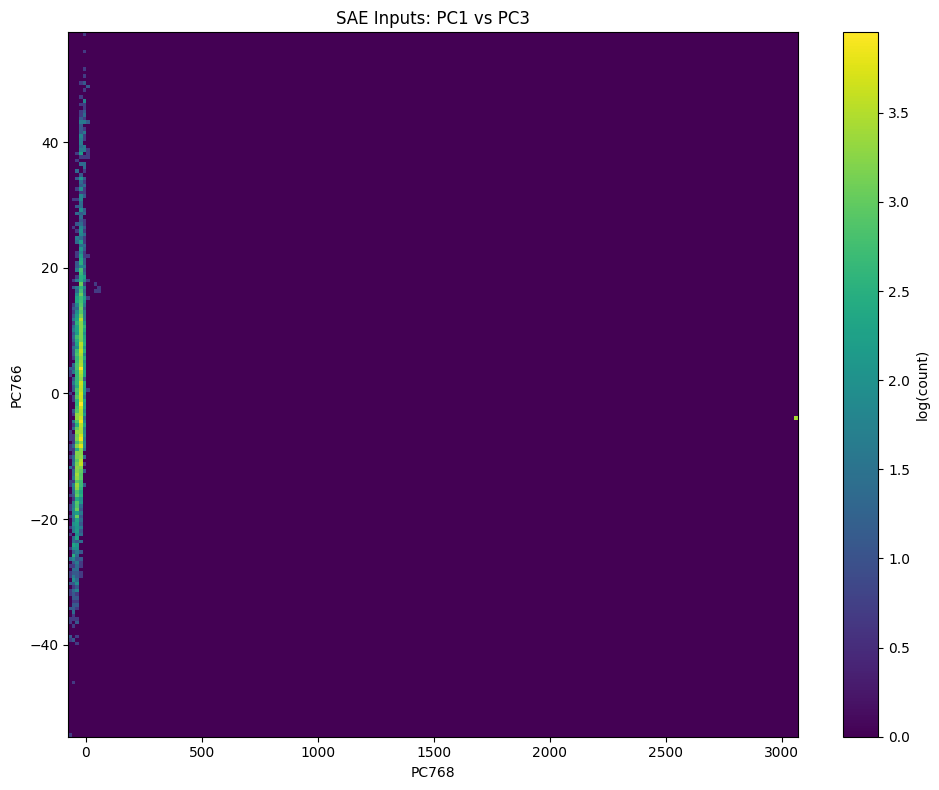

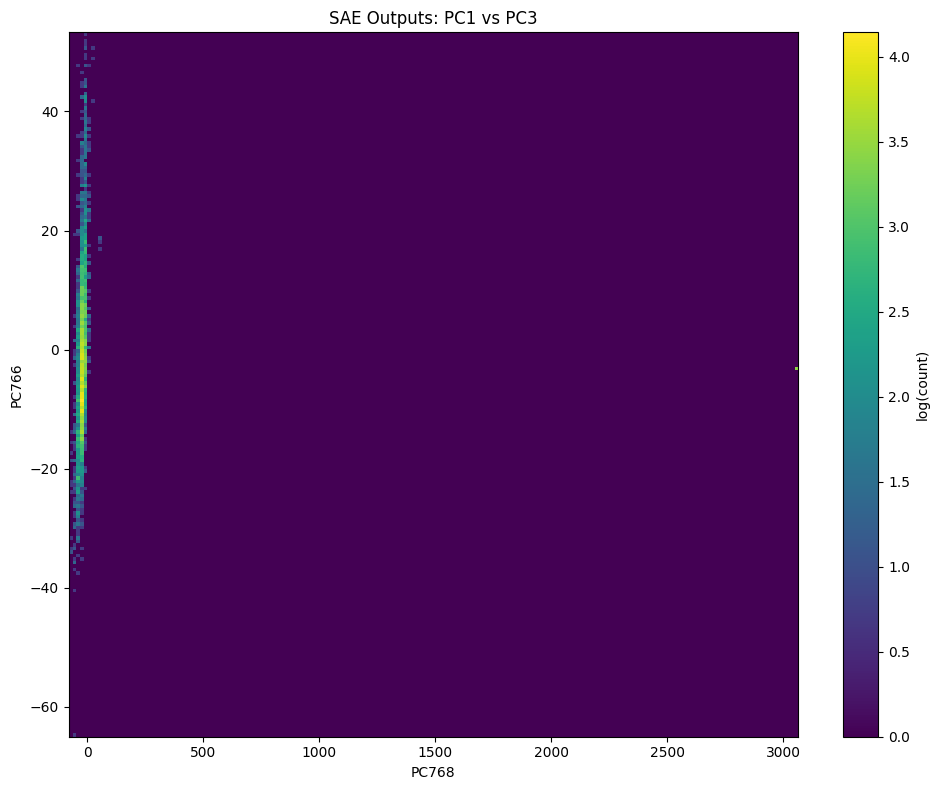

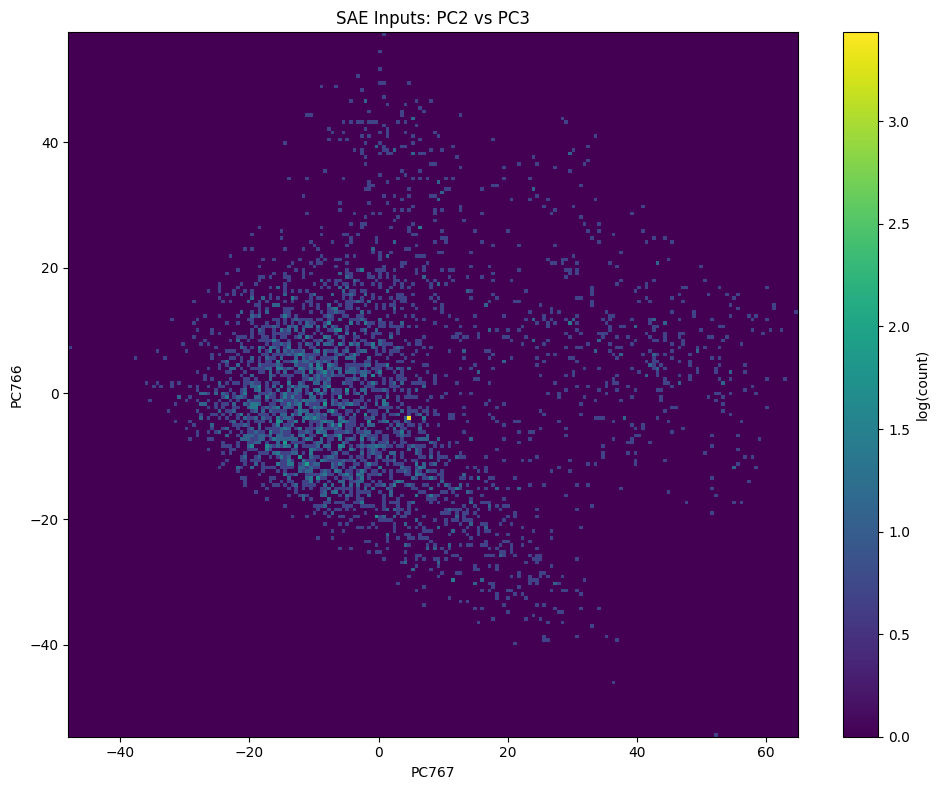

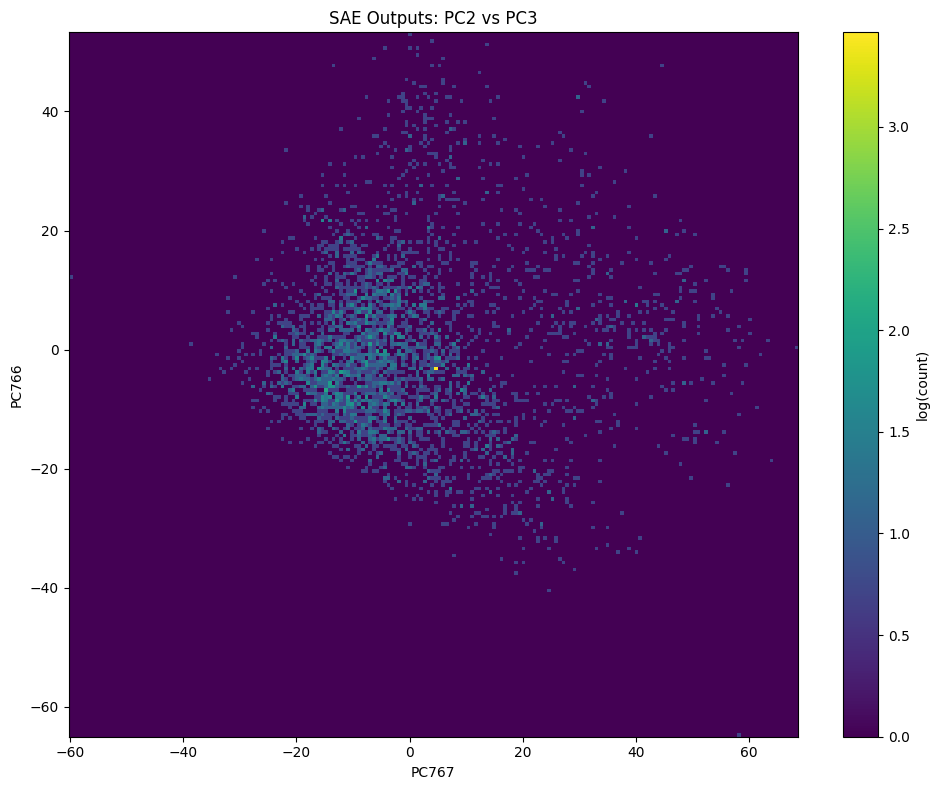

 83%|████████▎ | 10/12 [00:45<00:08,  4.49s/it]

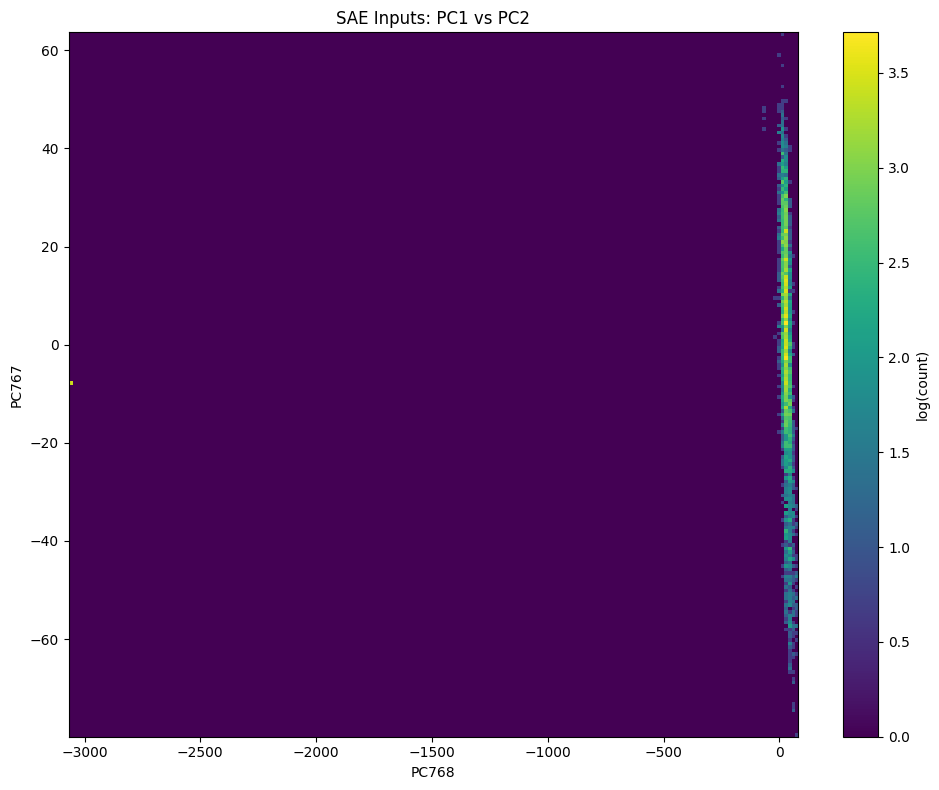

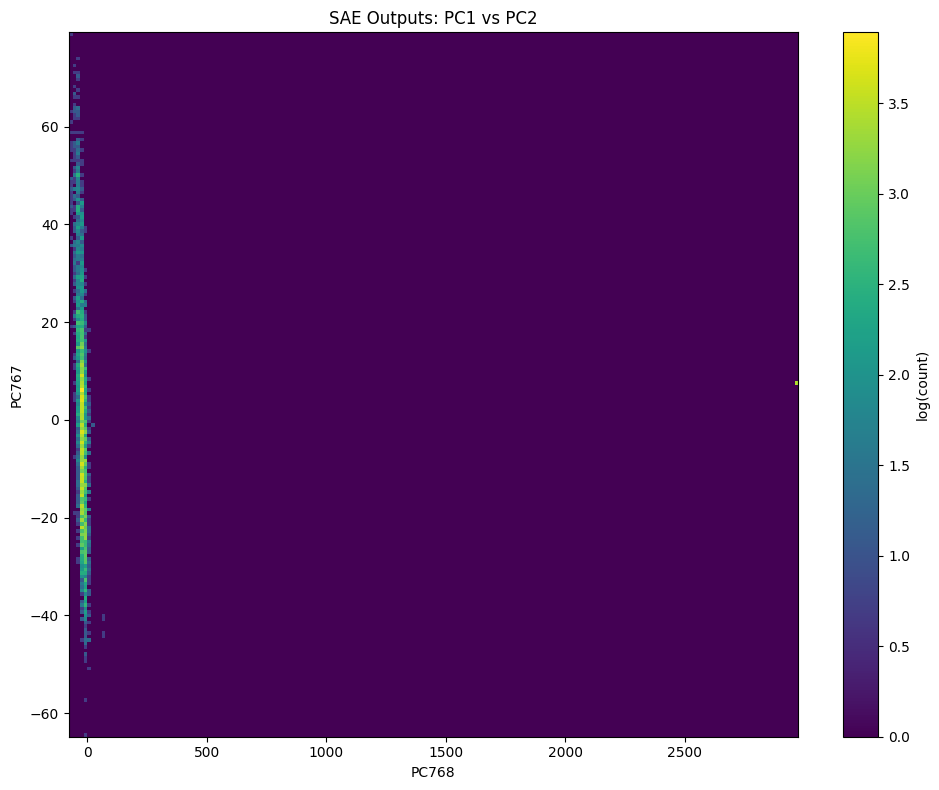

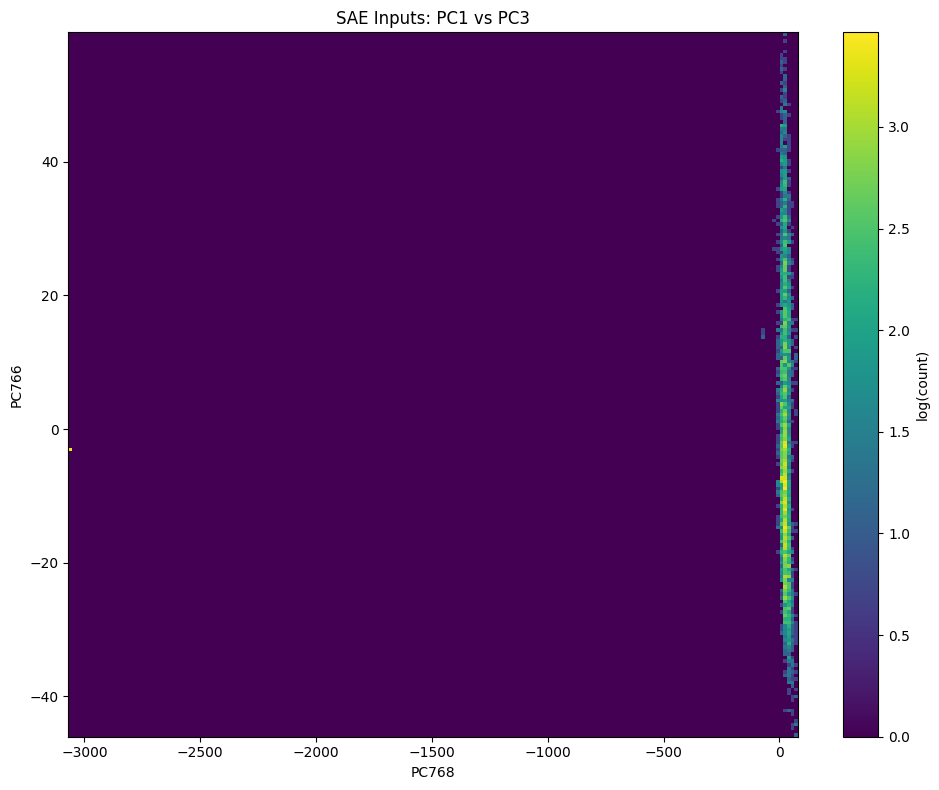

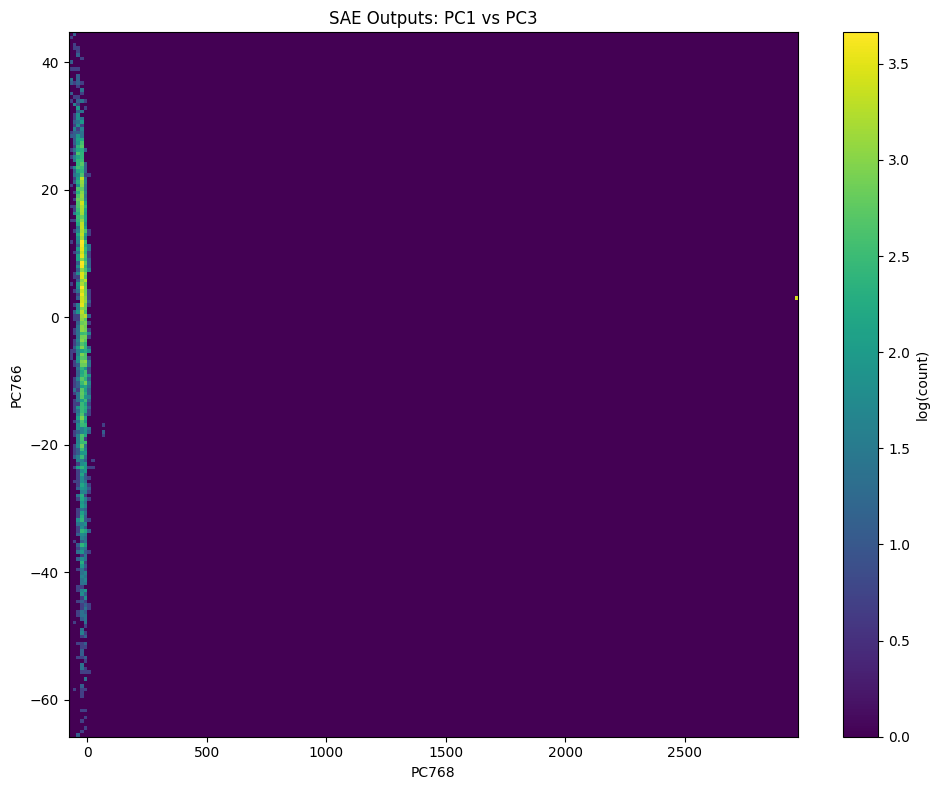

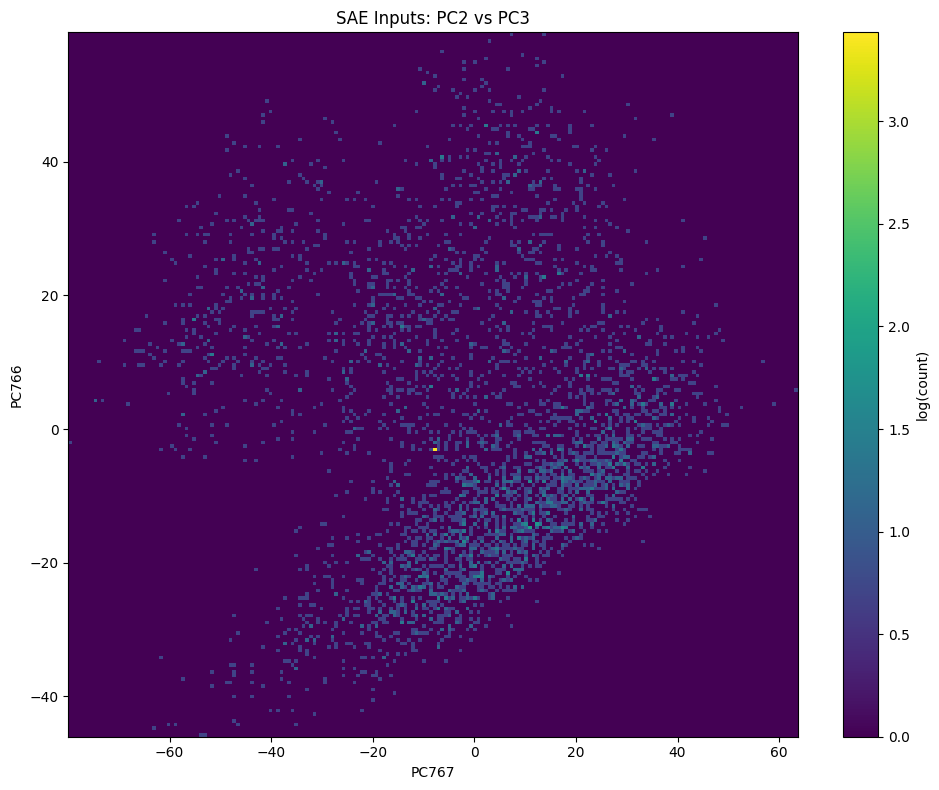

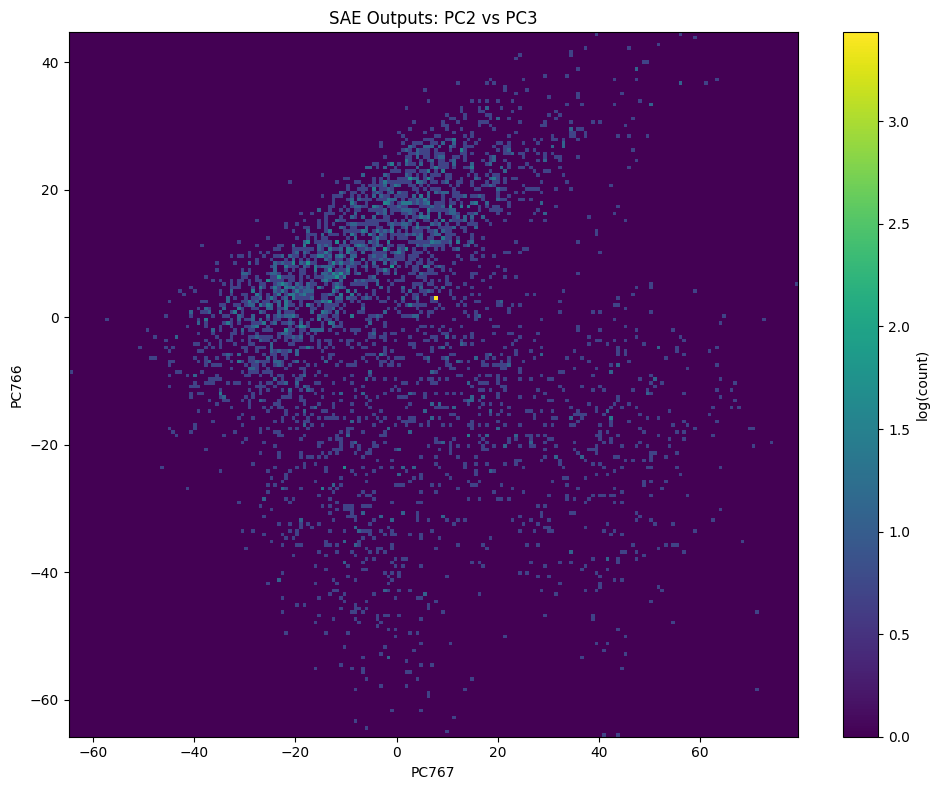

 92%|█████████▏| 11/12 [00:49<00:04,  4.49s/it]

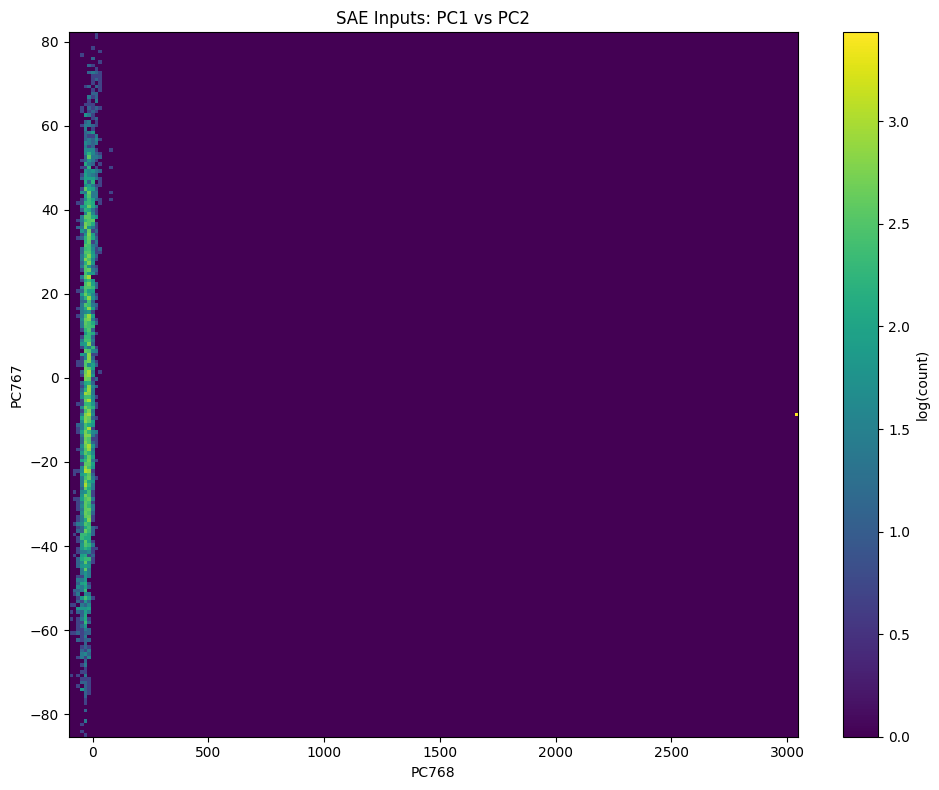

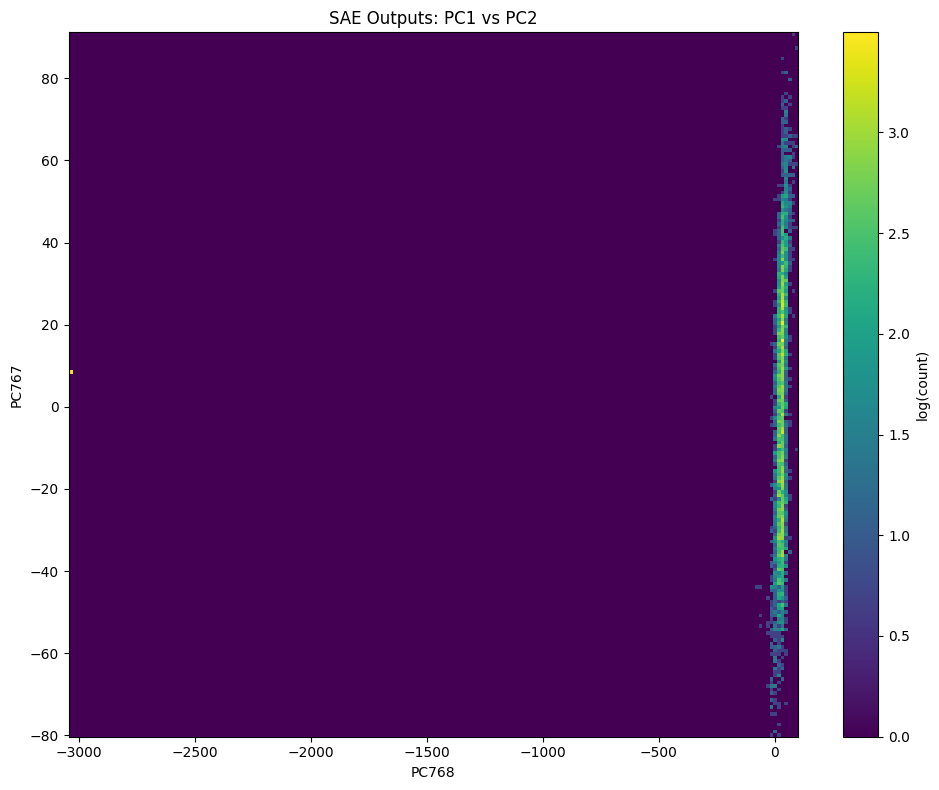

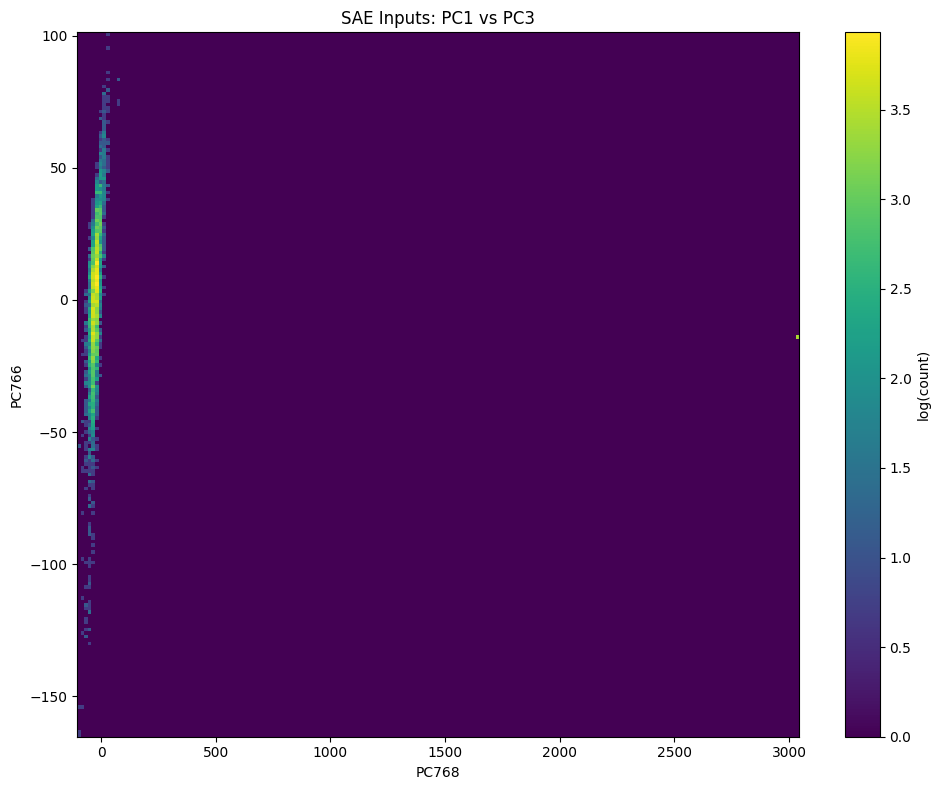

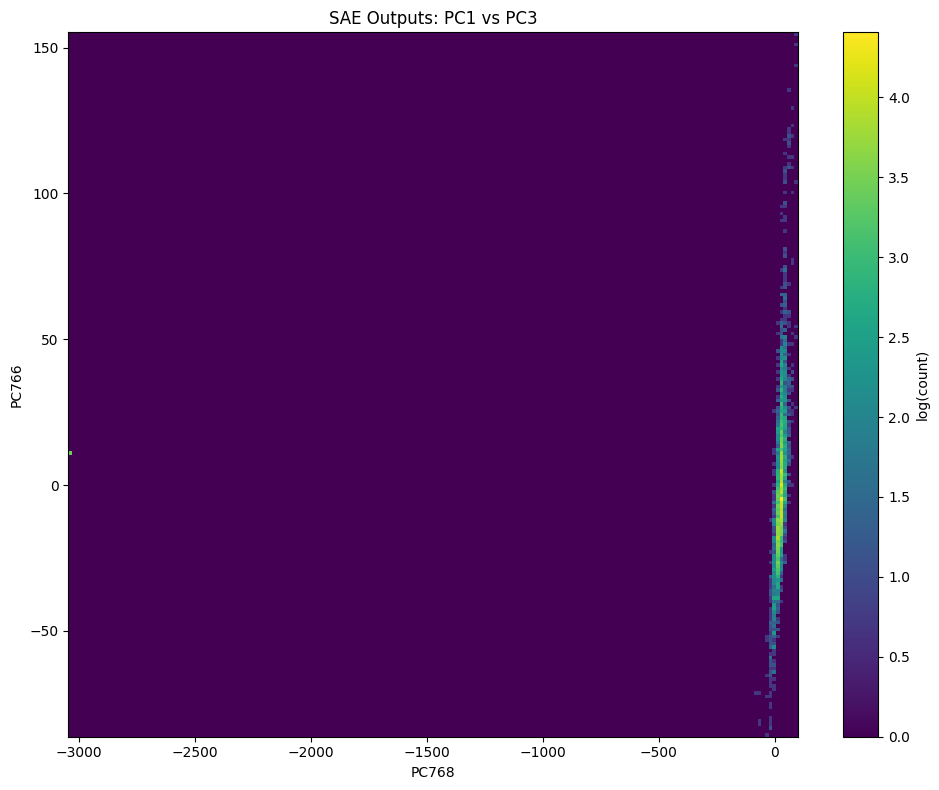

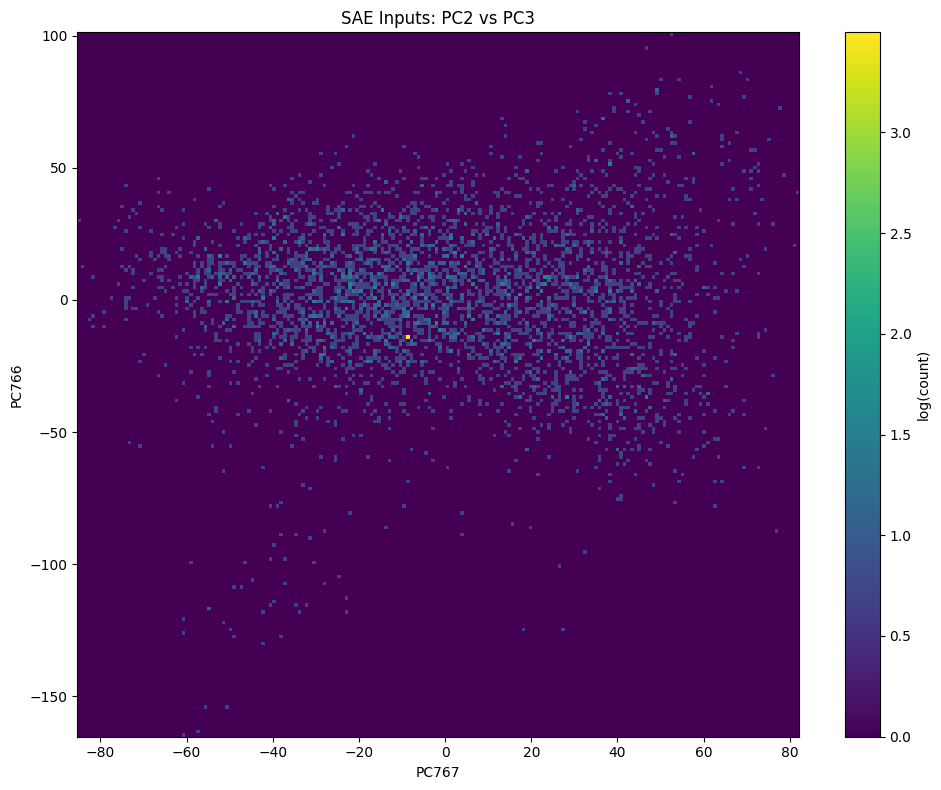

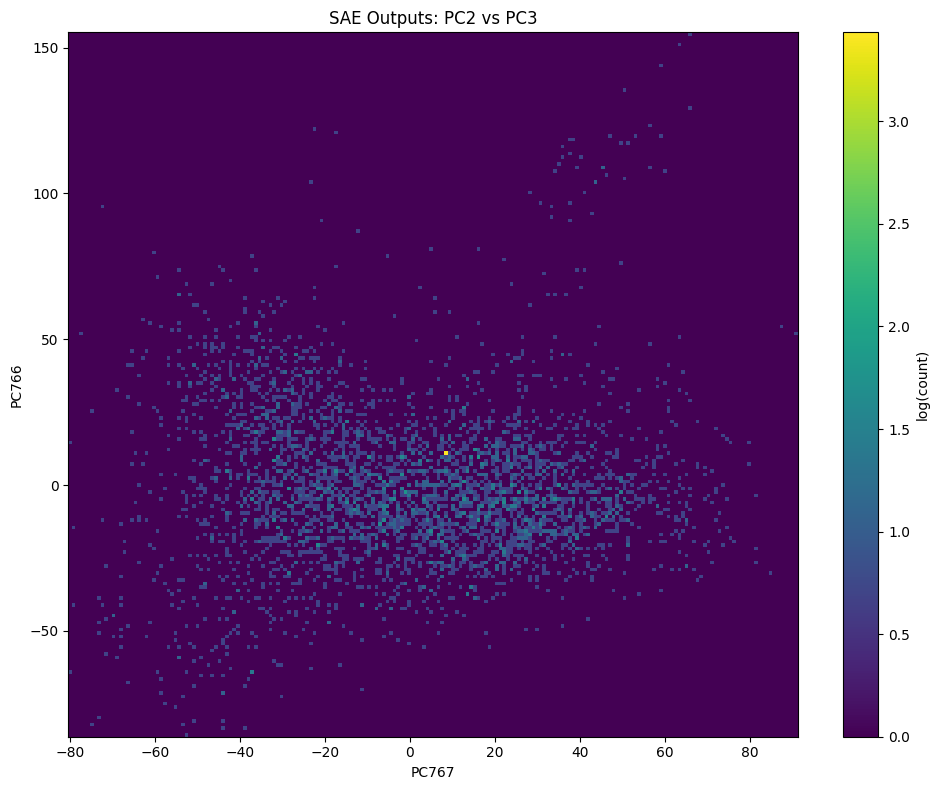

100%|██████████| 12/12 [00:54<00:00,  4.51s/it]


In [66]:
import numpy as np
def plot_pca_histogram(sae_flat, mean, eigenvectors, i, j, bins=200, title=None, save_to_file=None, reversed: bool = True):
    """
    Project SAE activations onto PCA components i and j and create a 2D histogram.
    
    Args:
        sae_flat: Tensor of shape [batch, dim]
        mean: Mean vector of shape [dim]
        eigenvectors: Matrix of eigenvectors of shape [dim, dim]
        i, j: Indices of PCA components to plot (0 is highest variance)
        bins: Number of histogram bins
        title: Optional title for the plot
        save_to_file: Optional path to save the plot
    """
    # Convert to numpy if needed
    if isinstance(sae_flat, torch.Tensor):
        sae_flat = sae_flat.cpu().numpy()
    if isinstance(mean, torch.Tensor):
        mean = mean.cpu().numpy()
    if isinstance(eigenvectors, torch.Tensor):
        eigenvectors = eigenvectors.cpu().numpy()
    
    # Get the PCA components (note: eigenvectors are in descending order of variance)
    # So we need to reverse the indices
    i = eigenvectors.shape[1] - 1 - i if reversed else i
    j = eigenvectors.shape[1] - 1 - j if reversed else j
    W = np.stack([eigenvectors[:, i], eigenvectors[:, j]])
    
    # Center the data
    X = sae_flat - mean
    
    # Project onto the PCA components
    P = X @ W.T
    
    # Create histogram bins
    x_min, x_max = P[:, 0].min(), P[:, 0].max()
    y_min, y_max = P[:, 1].min(), P[:, 1].max()
    x_bins = np.linspace(x_min, x_max, bins + 1)
    y_bins = np.linspace(y_min, y_max, bins + 1)
    
    # Create 2D histogram
    H, _, _ = np.histogram2d(P[:, 0], P[:, 1], bins=(x_bins, y_bins))
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(np.log1p(H).T, origin="lower", aspect="auto",
               extent=[x_min, x_max, y_min, y_max],
               cmap="viridis")
    plt.colorbar(label="log(count)")
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    if title:
        plt.title(title)
    plt.tight_layout()
    
    if save_to_file:
        plt.savefig(save_to_file, dpi=300)
    plt.show()
    plt.close()

# Example usage:
sae_in_pca_histograms_folder = Path("sae_in_pca_histograms")
sae_out_pca_histograms_folder = Path("sae_out_pca_histograms")
if sae_in_pca_histograms_folder.exists() and len(list(sae_in_pca_histograms_folder.glob("*"))) == 0:
    shutil.rmtree(sae_in_pca_histograms_folder)
if sae_out_pca_histograms_folder.exists() and len(list(sae_out_pca_histograms_folder.glob("*"))) == 0:
    shutil.rmtree(sae_out_pca_histograms_folder)
sae_in_pca_histograms_folder.mkdir(parents=True, exist_ok=False)
sae_out_pca_histograms_folder.mkdir(parents=True, exist_ok=False)
for layer in tqdm.trange(len(extractor.block2sae)):
    for i, j in [(0, 1), (0, 2), (1, 2)]:  # Plot first three PC pairs
        # For SAE inputs
        plot_pca_histogram(
            sae_in_flat[layer], 
            sae_in_flat_mean[layer].squeeze(), 
            eigenvectors_sae_ins[layer], 
            i, j,
            title=f"SAE Inputs: PC{i+1} vs PC{j+1}",
            save_to_file=sae_in_pca_histograms_folder / f"layer_{layer}_pc{i+1}_pc{j+1}.png"
        )
        
        # For SAE outputs
        plot_pca_histogram(
            sae_out_flat[layer], 
            sae_out_flat_mean[layer].squeeze(), 
            eigenvectors_sae_outs[layer], 
            i, j,
            title=f"SAE Outputs: PC{i+1} vs PC{j+1}",
            save_to_file=sae_out_pca_histograms_folder / f"layer_{layer}_pc{i+1}_pc{j+1}.png"
        )

In [ ]:
# l, r = einops.repeat(eigenvalues_sae_ins, "layer dim -> layer dim 1"), einops.repeat(eigenvalues_sae_outs, "layer dim -> layer 1 dim")
# print("l.shape", l.shape)
# eigenvalues_outer_product = einops.einsum(l, r, "layer dim1 dummy, layer dummy dim2 -> layer dim1 dim2")
# print("eigenvalues_outer_product.shape", eigenvalues_outer_product.shape)
# TBH this is not super useful :P
# for layer in range(len(extractor.block2sae)):
#     # plot a heatmap of the 768 x 768 matrix
#     plot_heatmap(
#         eigenvalues_outer_product[layer], 
#         f'Eigenvalues Outer Product (Layer {layer})',
#         'SAE Outs Eigenvectors',
#         'SAE Ins Eigenvectors'
#     )

In [8]:
# from transformer_lens import utils
# from functools import partial
# model = extractor.model
# sae = extractor.block2sae[8]

# # next we want to do a reconstruction test.
# def reconstr_hook(activation, hook, sae_out):
#     return sae_out


# def zero_abl_hook(activation, hook):
#     return torch.zeros_like(activation)


# print("Orig", model(batch_tokens, return_type="loss").item())
# print(
#     "reconstr",
#     model.run_with_hooks(
#         batch_tokens,
#         fwd_hooks=[
#             (
#                 sae.cfg.hook_name,
#                 partial(reconstr_hook, sae_out=sae_out[8]),
#             )
#         ],
#         return_type="loss",
#     ).item(),
# )
# print(
#     "Zero",
#     model.run_with_hooks(
#         batch_tokens,
#         return_type="loss",
#         fwd_hooks=[(sae.cfg.hook_name, zero_abl_hook)],
#     ).item(),
# )

In [9]:
# example_prompt = "When John and Mary went to the shops, John gave the bag to"
# example_answer = " Mary"
# utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

# logits, cache = model.run_with_cache(example_prompt, prepend_bos=True)
# tokens = model.to_tokens(example_prompt)
# sae_out = sae(cache[sae.cfg.hook_name])


# def reconstr_hook(activations, hook, sae_out):
#     return sae_out


# def zero_abl_hook(mlp_out, hook):
#     return torch.zeros_like(mlp_out)


# hook_name = sae.cfg.hook_name

# print("Orig", model(tokens, return_type="loss").item())
# print(
#     "reconstr",
#     model.run_with_hooks(
#         tokens,
#         fwd_hooks=[
#             (
#                 hook_name,
#                 partial(reconstr_hook, sae_out=sae_out),
#             )
#         ],
#         return_type="loss",
#     ).item(),
# )
# print(
#     "Zero",
#     model.run_with_hooks(
#         tokens,
#         return_type="loss",
#         fwd_hooks=[(hook_name, zero_abl_hook)],
#     ).item(),
# )


# with model.hooks(
#     fwd_hooks=[
#         (
#             hook_name,
#             partial(reconstr_hook, sae_out=sae_out),
#         )
#     ]
# ):
#     utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

In [ ]:
# from sae_dashboard.sae_vis_data import SaeVisConfig
# from sae_dashboard.sae_vis_runner import SaeVisRunner
# device = "cuda"
# test_feature_idx_gpt = list(range(10)) + [14057]

# feature_vis_config_gpt = SaeVisConfig(
#     hook_point=hook_name,
#     features=test_feature_idx_gpt,
#     minibatch_size_features=64,
#     minibatch_size_tokens=256,
#     verbose=True,
#     device=device,
# )

# visualization_data_gpt = SaeVisRunner(
#     feature_vis_config_gpt
# ).run(
#     encoder=sae,  # type: ignore
#     model=model,
#     tokens=token_dataset[:10000]["tokens"],  # type: ignore
# )
# # SaeVisData.create(
# #     encoder=sae,
# #     model=model, # type: ignore
# #     tokens=token_dataset[:10000]["tokens"],  # type: ignore
# #     cfg=feature_vis_config_gpt,
# # )

In [ ]:
# from sae_dashboard.data_writing_fns import save_feature_centric_vis

# filename = f"demo_feature_dashboards.html"
# save_feature_centric_vis(sae_vis_data=visualization_data_gpt, filename=filename)

In [ ]:
# from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

# # this function should open
# neuronpedia_quick_list = get_neuronpedia_quick_list(sae, test_feature_idx_gpt)

# print(neuronpedia_quick_list)